# Supplementary data analysis and figures
This notebook contains code to analyze paper reuslts and generate figures in the supplementary information for the paper __[Kinetic sequencing (*k*-Seq) as a massively parallel assay for ribozyme kinetics: utility and critical parameters](https://www.biorxiv.org/content/10.1101/2020.12.02.407346v1)__

## Environment setup

Set up the workspace environment

In [1]:
# Path to data downloaded from our Dryad deposit
PAPER_DATA_DIR = '/Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/'

# Path to output figures
FIG_OUTPUT_DIR = '/Users/yuning/Desktop/kseq-NAR-revision-fig'

# Path to k-seq repository (load k_seq package locally)
K_SEQ_REP_DIR = '/Users/yuning/research/k-seq/'

# display resolution
DISP_RES = 80

In [2]:
# You wouldn't need to change this part

## Jedi autocompletion performs funky in Jupyter notebook, disable it
from IPython import get_ipython
get_ipython().Completer.use_jedi = False
get_ipython().Completer.limit_to__all__ = True


## Add repo path to load k-seq package locally (paper version)
from pathlib import Path
import sys
sys.path.insert(0, str(Path(K_SEQ_REP_DIR) / 'src'))
## Link data path and figure output path 
import os
os.environ['PAPER_DATA_DIR'] = PAPER_DATA_DIR
if PAPER_DATA_DIR != '':
    Path(FIG_OUTPUT_DIR).mkdir(exist_ok=True, parents=True)

import pandas as pd
import numpy as np

# plotting setup
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = DISP_RES

marker_map = {'0': 'o', '1': 'o', '2': '^', '3': 's'}
color_map = {'R': '#AEAEAE', 'A': '#2C73B4', 'B': '#70C7C7',
             'C': '#1C7725', 'D':'#F39730', 'E': '#B2112A'}
from k_seq.utility import plot_tools
default_palette = plot_tools.Presets.color_cat10
label_map = {'A': '1250 μM', 'B': '250 μM', 'C': '50 μM', 
             'D': '10 μM', 'E': '2 μM',
             'R': 'Unreacted'}

/Users/yuning/miniconda3/envs/k-seq/lib/python3.8/site-packages/IPython/core/completer.py:1044: UserWarning: `IPython.core.IPCompleter.limit_to__all__` configuration value has been deprecated since IPython 5.0, will be made to have no effects and then removed in future version of IPython.
  warnings.warn('`IPython.core.IPCompleter.limit_to__all__` configuration '


In [3]:
# function to load k-seq results

def load_variant_pool():
    if 'variant_pool' not in globals().keys():
        print('loading variant_pool')
        from k_seq.utility import file_tools
        global variant_pool
        variant_pool = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-variant/byo-variant.pkl")
        variant_pool.update_analysis()
    else:
        print('variant_pool found')
    
    if 'variant_pool_res' not in globals().keys():
        print('loading variant_pool_res')
        from k_seq.estimate.least_squares_batch import BatchFitResults
        from k_seq.estimate.model_ident import gamma
        global variant_pool_res
        variant_pool_res = BatchFitResults.load_result(f'{PAPER_DATA_DIR}/results/experimental/byo-variant/all-seq_bs-100')
        variant_pool_res.summary['gamma'] = gamma(variant_pool_res.summary)
    else:
        print('variant_pool_res found')

def load_variant_pool_res_double_mutants():
    if 'variant_pool_res_double_mutants' not in globals().keys():
        print('loading variant_pool_res_double_mutants')
        from k_seq.estimate.least_squares_batch import BatchFitResults
        from k_seq.estimate.model_ident import gamma
        global variant_pool_res_double_mutants
        variant_pool_res_double_mutants = BatchFitResults.load_result(f'{PAPER_DATA_DIR}/results/experimental/byo-variant/double-mutants_bs-100')
        variant_pool_res_double_mutants.summary['gamma'] = gamma(variant_pool_res_double_mutants.summary)
    else:
        print('variant_pool_res_double_mutants found')
        
def load_enriched_pool():
    if 'enriched_pool' not in globals().keys():
        from k_seq.utility import file_tools
        print('loading enriched_pool')
        global enriched_pool
        enriched_pool = file_tools.read_pickle(f"{PAPER_DATA_DIR}/data/byo-enriched/byo-enriched.pkl")
        enriched_pool.update_analysis()
    else:
        print('enriched_pool found')
    
    if 'enriched_pool_res' not in globals().keys():
        print('loading enriched_pool_res')
        from k_seq.estimate.least_squares_batch import BatchFitResults
        global enriched_pool_res
        enriched_pool_res = BatchFitResults.load_result(f'{PAPER_DATA_DIR}/results/experimental/byo-enriched/all-seq_bs-100')
    else:
        print('enriched_pool_res found')


def load_simu_count():
    if 'simu_count' not in globals().keys():
        print('loading simu_count')
        from k_seq.data import simu
        global simu_count
        simu_count = simu.SimulationResults(
            dataset_dir=f"{PAPER_DATA_DIR}/results/simu-count/simu-count.pkl",
            result_dir=f'{PAPER_DATA_DIR}/results/simu-count/all-seq_bs-100/'
        )
    else:
        print('simu_count found')
        

def load_simu_react_frac():
    if 'simu_react_frac' not in globals().keys():
        print('loading simu_react_frac')
        global simu_react_frac
        from k_seq.estimate.model_ident import ParamMap
        simu_react_frac = {
            'Relative error = 0': ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr0'),
            'Relative error = 0.2': ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr02'),
            'Relative error = 0.5': ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr05'),
            'Relative error = 1.0': ParamMap.load_result(f'{PAPER_DATA_DIR}/results/simu-react-frac/extended-relErr10')
        }
    else:
        print('simu_react_frac found')

## Figure S1: qPCR standard curves

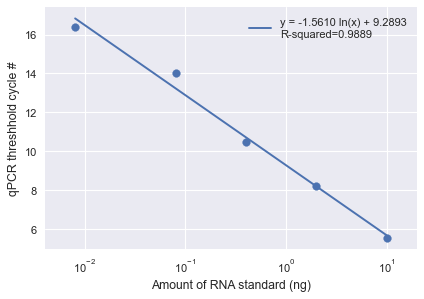

In [4]:
qPCR_sc = pd.read_csv(f'{PAPER_DATA_DIR}/data/qPCR-standard.csv')

plot_tools.regplot(
    x=qPCR_sc['Amount of RNA standard (ng)'], y=qPCR_sc['qPCR threshhold cycle #'],
    xlog=True, ylog=False
)
plt.gcf().savefig(f'{FIG_OUTPUT_DIR}/fig-s1.pdf')

## Figure S2: RNA quantification standard deviation

loading variant_pool


INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/experimental/byo-variant/all-seq_bs-100...


loading variant_pool_res


INFO:root:'seqs.tar.gz' found


Percent standard deviation of total RNA amount
Measured by qPCR: 0.176
Measured by spike-in: 0.165


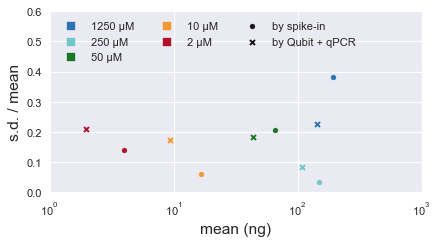

In [5]:
load_variant_pool()

dna_amount = pd.DataFrame({
    'total amount (spike-in, ng)': variant_pool.spike_in.norm_factor * variant_pool.table.filtered.sum(axis=0),
    'total amount (sample total, ng)': pd.Series(variant_pool.sample_total.norm_factor) * variant_pool.table.filtered.sum(axis=0)
})

rel_sd = {'Qubit + qPCR': [], 'spike-in': []}

fig, ax = plt.subplots(1, 1, figsize=(6, 3))

for byo, color in color_map.items():
    samples = [sample for sample in dna_amount.index if sample[0] == byo]
    x_mean = dna_amount.loc[samples, 'total amount (spike-in, ng)'].mean()
    x_sd = dna_amount.loc[samples, 'total amount (spike-in, ng)'].std()
    y_mean = dna_amount.loc[samples, 'total amount (sample total, ng)'].mean()
    y_sd = dna_amount.loc[samples, 'total amount (sample total, ng)'].std()
    
    if byo != 'R':
        ax.scatter(x=[x_mean], y=[x_sd / x_mean], marker='o', s=20, color=color)
        ax.scatter(x=[y_mean], y=[y_sd / y_mean], marker='x', s=20, color=color)
        ax.scatter([], [], color=color, marker='s', s=50, label=label_map[byo])
        rel_sd['Qubit + qPCR'].append(y_sd / y_mean)
        rel_sd['spike-in'].append(x_sd / x_mean)
        
ax.scatter([],[], marker='o', s=20, color='#151515', label='by spike-in')  
ax.scatter([],[], marker='x', s=20, color='#151515', label='by Qubit + qPCR')
ax.set_xscale('log')
ax.set_xlim([1, 1000])
ax.set_ylim([0, 0.6])
ax.legend(loc='upper left', ncol=3)
ax.set_xlabel('mean (ng)', fontsize=14)
ax.set_ylabel('s.d. / mean', fontsize=14)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s2.pdf', bbox_inches='tight')

print('Percent standard deviation of total RNA amount')
print(f"Measured by qPCR: {np.mean(rel_sd['Qubit + qPCR']):.3}")
print(f"Measured by spike-in: {np.mean(rel_sd['spike-in']):.3}")

## Figure S4 - S9: example fitting curves from simulated dataset

In [4]:
def get_seq_subset(exp, kA_range=None, A_range=None, k_range=None):
    """Filter the sequences based on the range of kA, A, and k,
    Returns:
        pd.DataFrame of simulated sequence parameter for those satisfy the condition
    """

    flag = pd.Series(np.repeat(True, len(exp.parameters)), index=exp.parameters.index)
    if kA_range is not None:
        flag = flag & (exp.parameters.k * exp.parameters.A > kA_range[0]) & (exp.parameters.k * exp.parameters.A < kA_range[1])
    if k_range is not None:
        flag = flag & (exp.parameters.k > k_range[0]) & (exp.parameters.k < k_range[1])
    if A_range is not None:
        flag = flag & (exp.parameters.A > A_range[0]) & (exp.parameters.A < A_range[1])

    return exp.parameters[flag].index

def get_regions(exp=None, func=False):
    """Get 6 regions divided in simulation"""
    if func:
        from functools import partial
        return [
            partial(get_seq_subset, A_range=(0.1, 1.0), kA_range=(0.1, 1)),
            partial(get_seq_subset, A_range=(0.1, 1.0), kA_range=(1, 10)),
            partial(get_seq_subset, A_range=(0.1, 1.0), kA_range=(10, np.inf)),
            partial(get_seq_subset, A_range=(0.01, 0.1), kA_range=(0.1, 1)),
            partial(get_seq_subset, A_range=(0.01, 0.1), kA_range=(1, 10)),
            partial(get_seq_subset, A_range=(0.01, 0.1), kA_range=(10, np.inf))
        ]
    else:
        return [
            get_seq_subset(exp, A_range=(0.1, 1.0), kA_range=(0.1, 1)),
            get_seq_subset(exp, A_range=(0.1, 1.0), kA_range=(1, 10)),
            get_seq_subset(exp, A_range=(0.1, 1.0), kA_range=(10, np.inf)),
            get_seq_subset(exp, A_range=(0.01, 0.1), kA_range=(0.1, 1)),
            get_seq_subset(exp, A_range=(0.01, 0.1), kA_range=(1, 10)),
            get_seq_subset(exp, A_range=(0.01, 0.1), kA_range=(10, np.inf))
        ]

def simu_react_frac_example_curves_by_region(exps, seq_filter_fn, n_example=10, curve_type='bootstrap', figsize=None, fontsize=12, single_figsize=1.8, heatmap_resolution=100, save_to=None):
    """Plot example fitting curves and loss function map for sequence fitting results and conditioned provided in exps"""
    from k_seq.utility import plot_tools
    
    n_cond = len(exps)
    fig, axes = plt.subplots(2 * n_cond, n_example, figsize=(single_figsize * n_example * 1.1, single_figsize * 2 * n_cond))
    
    if curve_type.lower() in ['bs', 'bootstrap', 'bootstrapping']:
        plot_on='bootstrap'
    elif curve_type.lower() in ['conv', 'convergence', 'repeated fitting', 'rep fit']:
        plot_on='convergence'
    else:
        raise ValueError("Please pass 'bootstrap' or 'convergence' to curve_type")
    
    for ix, (name, exp) in enumerate(exps.items()):
        seq_list = seq_filter_fn(exp)
        
        if len(seq_list) > n_example:
            seq_list = np.random.choice(seq_list, size=n_example, replace=False)
        
        for seq, ax in zip(seq_list, axes[ix * 2]):
            exp.results.get_FitResult(seq).plot_fitting_curves(
                plot_on=plot_on, ax=ax, x_label='BYO (M)', 
                x_lim=(-0.0001, 0.002),
                fontsize=fontsize, y_label='react. frac.'
            )
            from math import ceil
            y_lim = ax.get_ylim()
            digits = int(np.log10(y_lim[1]))
            y_top = ceil(y_lim[1] / 10 ** digits * 10) * 10 ** digits / 10
            
            ax.set_ylim((y_lim[0], y_top))
            ax.set_yticks([0, y_top])
            ax.set_xticks([0, 0.002])
            ax.set_xticklabels(['0', '0.002'])
            
            
        for seq, ax in zip(seq_list, axes[ix * 2 + 1]):
            exp.results.get_FitResult(seq).plot_loss_heatmap(
                plot_on=plot_on, ax=ax,
                colorbar=False,
                fontsize=fontsize, add_lines=[1],
                tick_num=2, line_label=False,
                resolution=heatmap_resolution
            )
            ax.set_xticks([0, heatmap_resolution])
            ax.set_xticklabels(['$10^{-2}$', '$10^4$'])
            ax.set_yticks([0, heatmap_resolution])
            ax.set_yticklabels(['$10^{-3}$', '$10^{0}$'])
            
        fig.text(s=name, x=0, y=1 - (ix * 2 + 1) / (n_cond * 2), ha='right', va='center', fontsize=14, rotation=90)

    plt.tight_layout()

INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr0...
INFO:root:'seqs.tar.gz' found


loading simu_react_frac


INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr02...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr05...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr10...
INFO:root:'seqs.tar.gz' found


--------------------Region 1--------------------


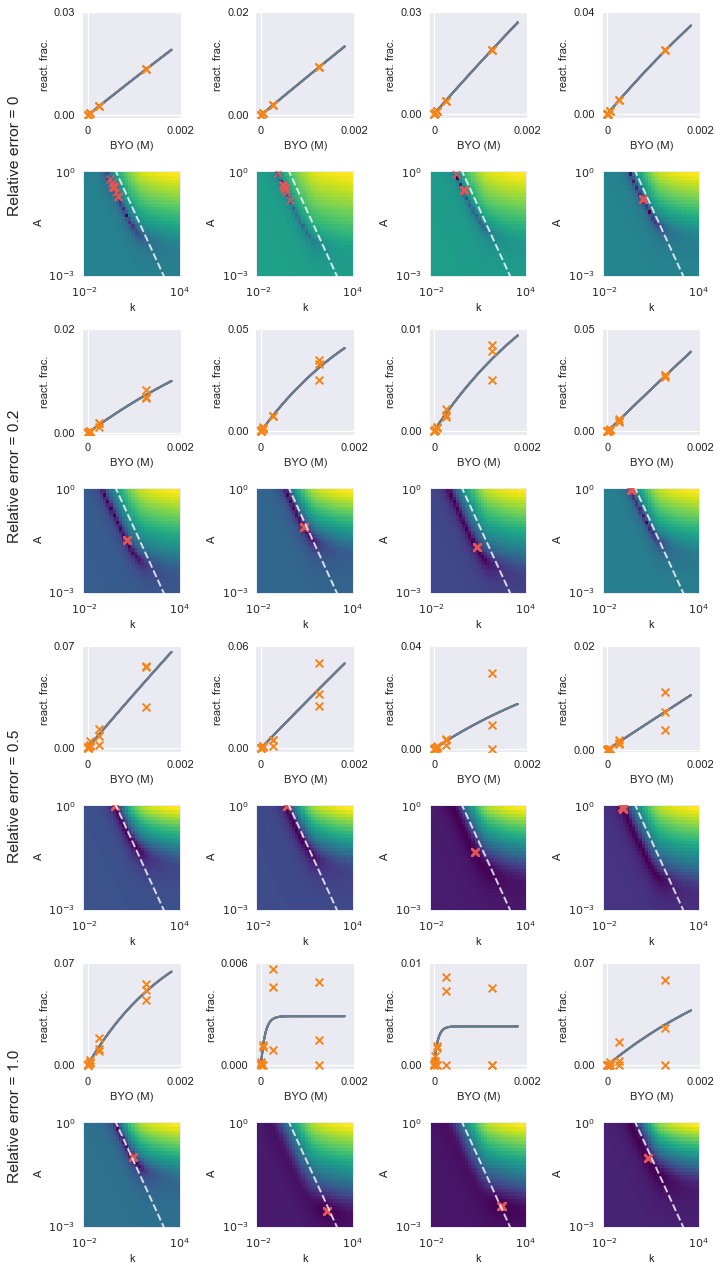

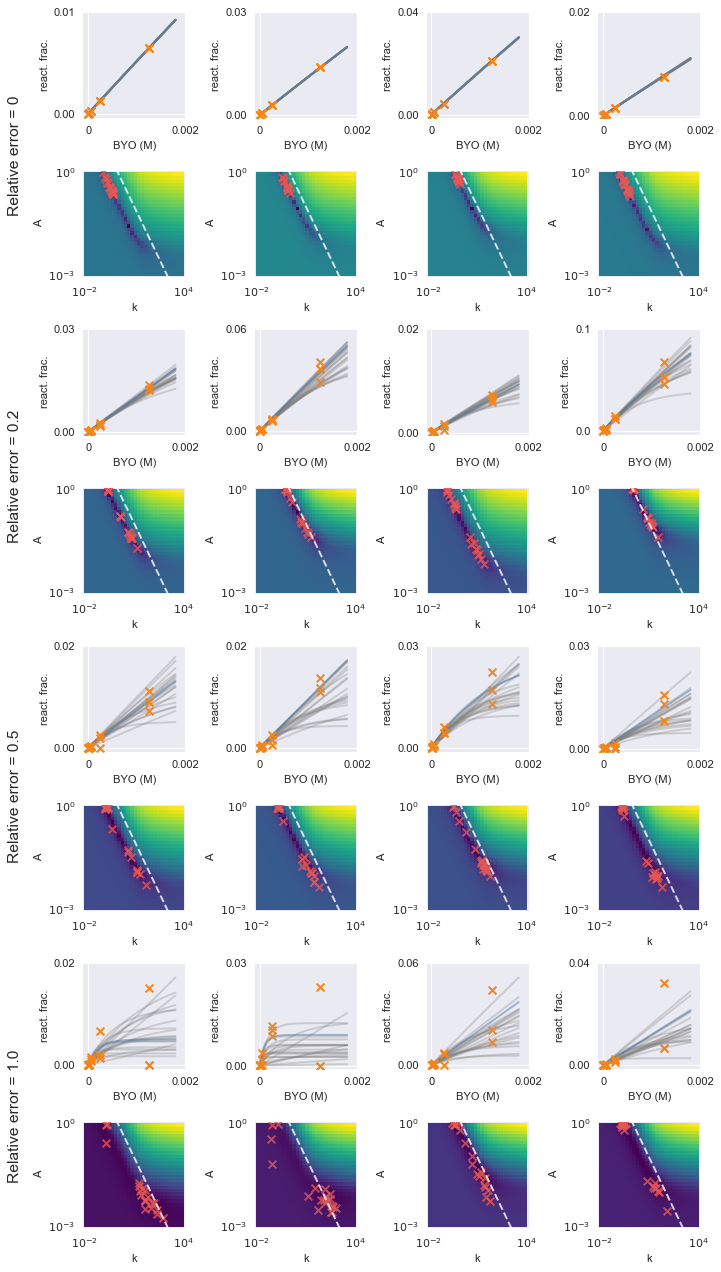

--------------------Region 2--------------------


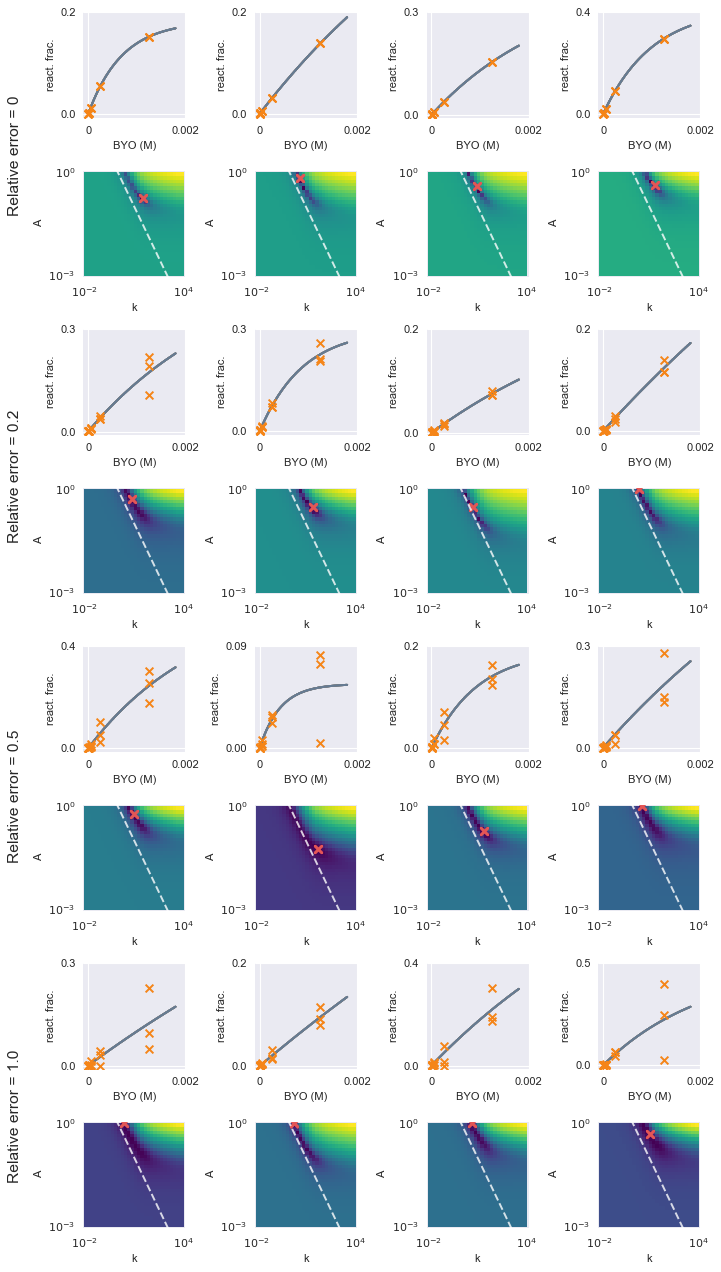

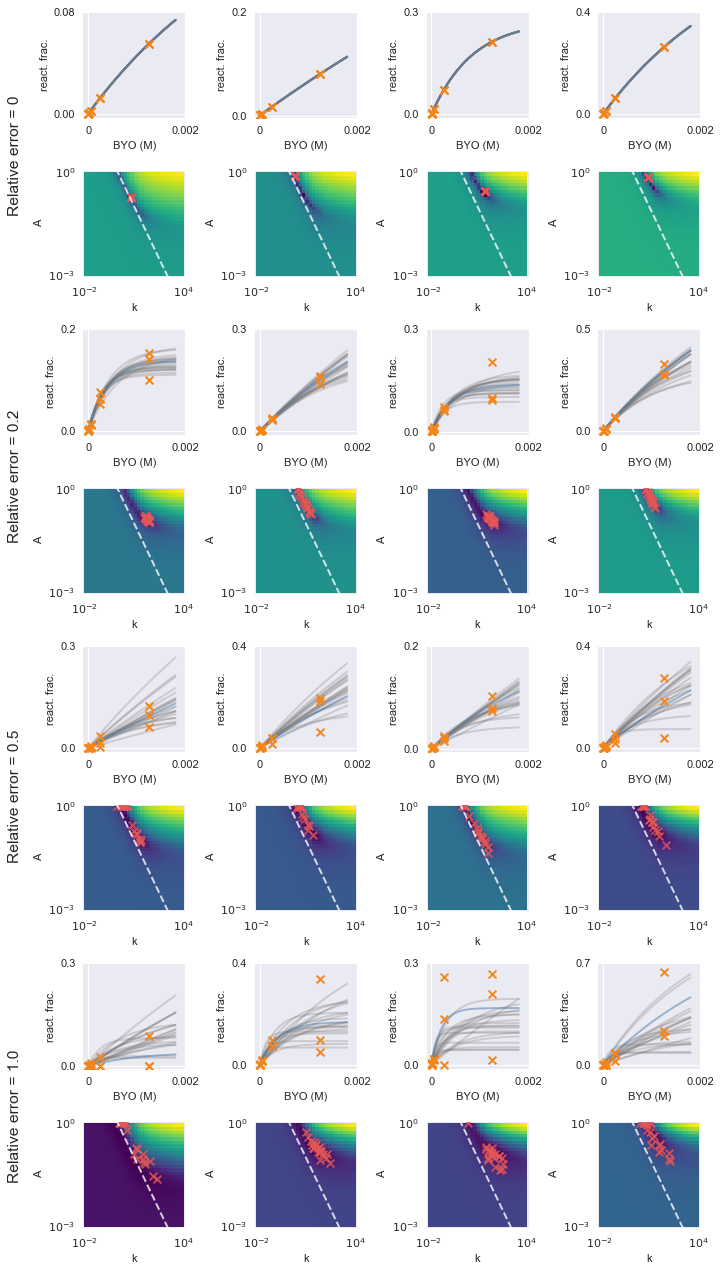

--------------------Region 3--------------------


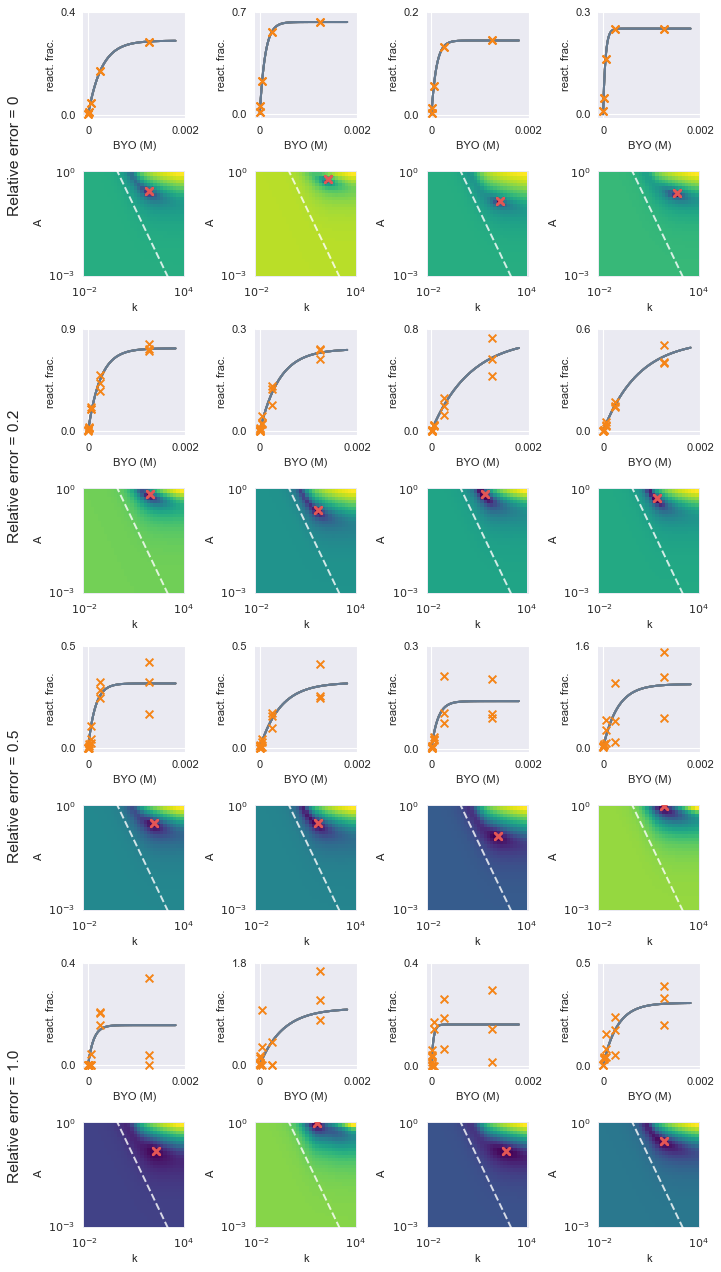

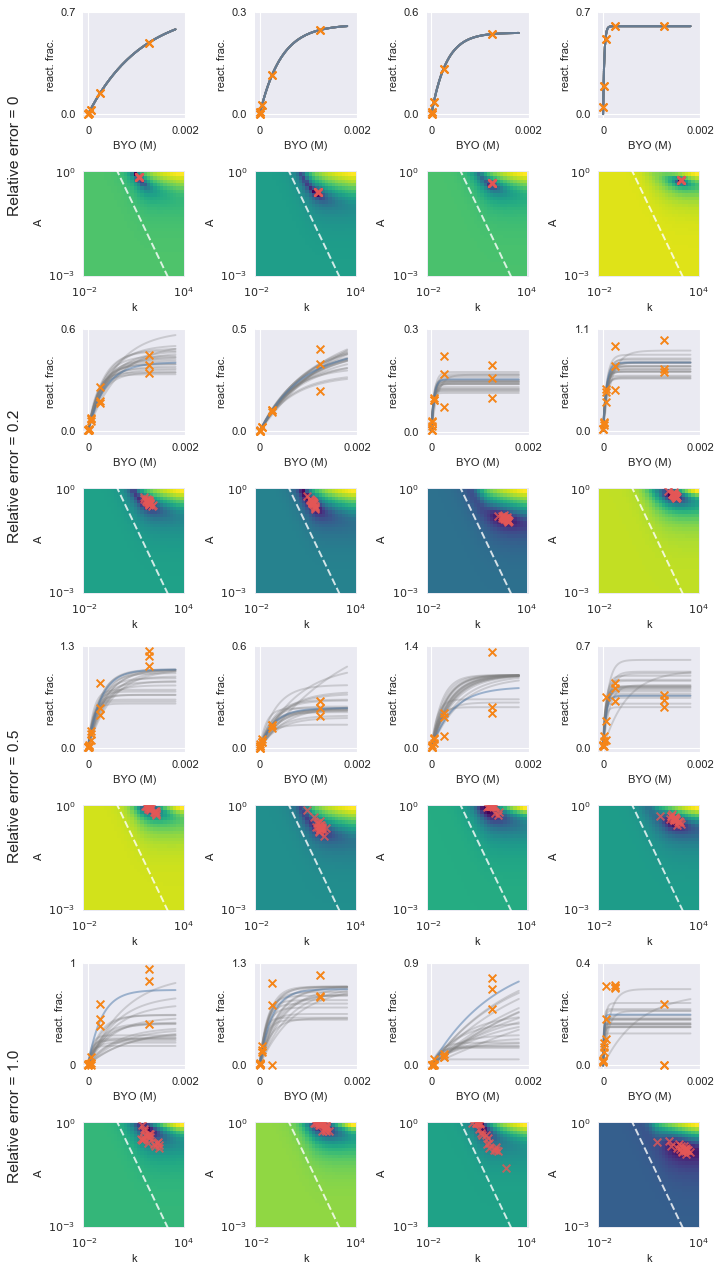

--------------------Region 4--------------------


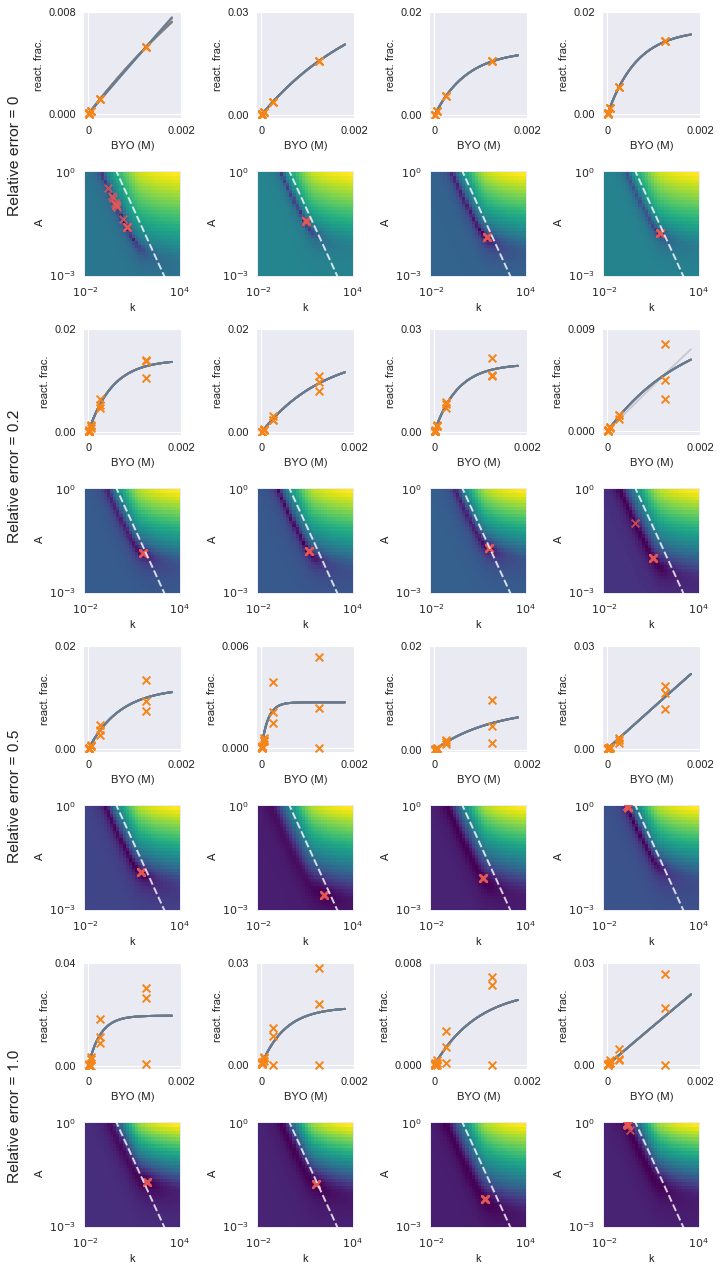

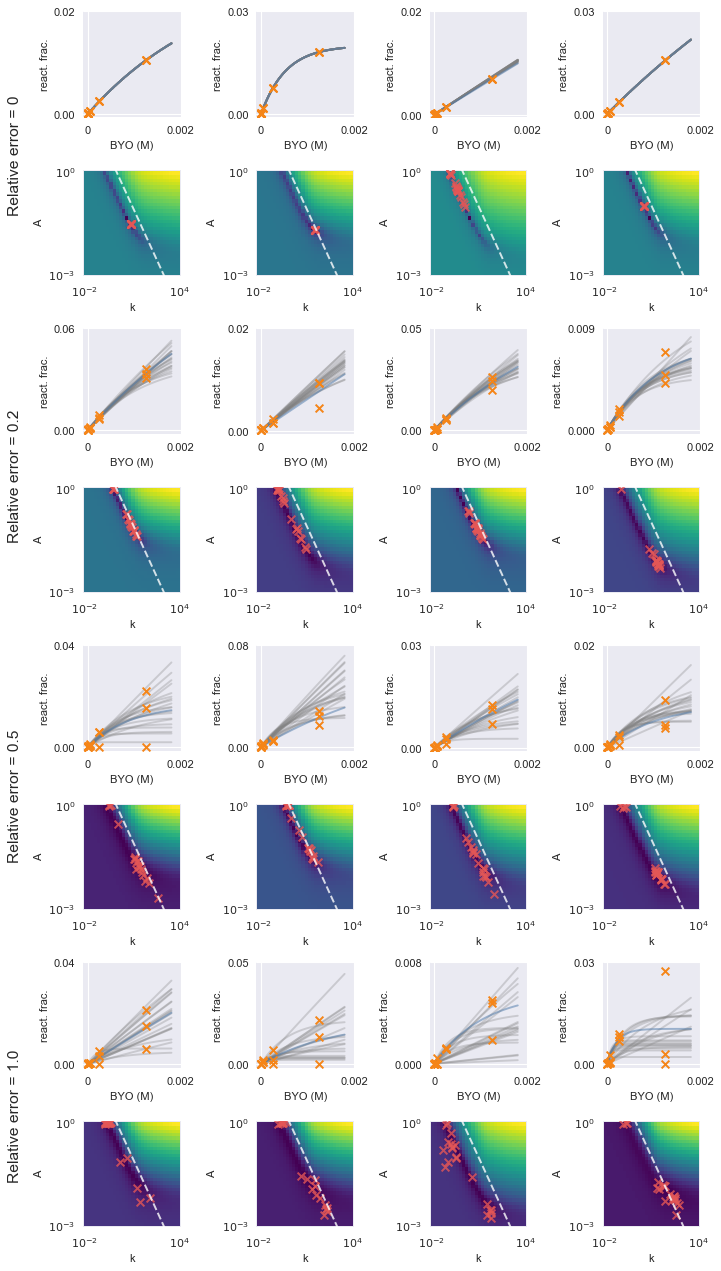

--------------------Region 5--------------------


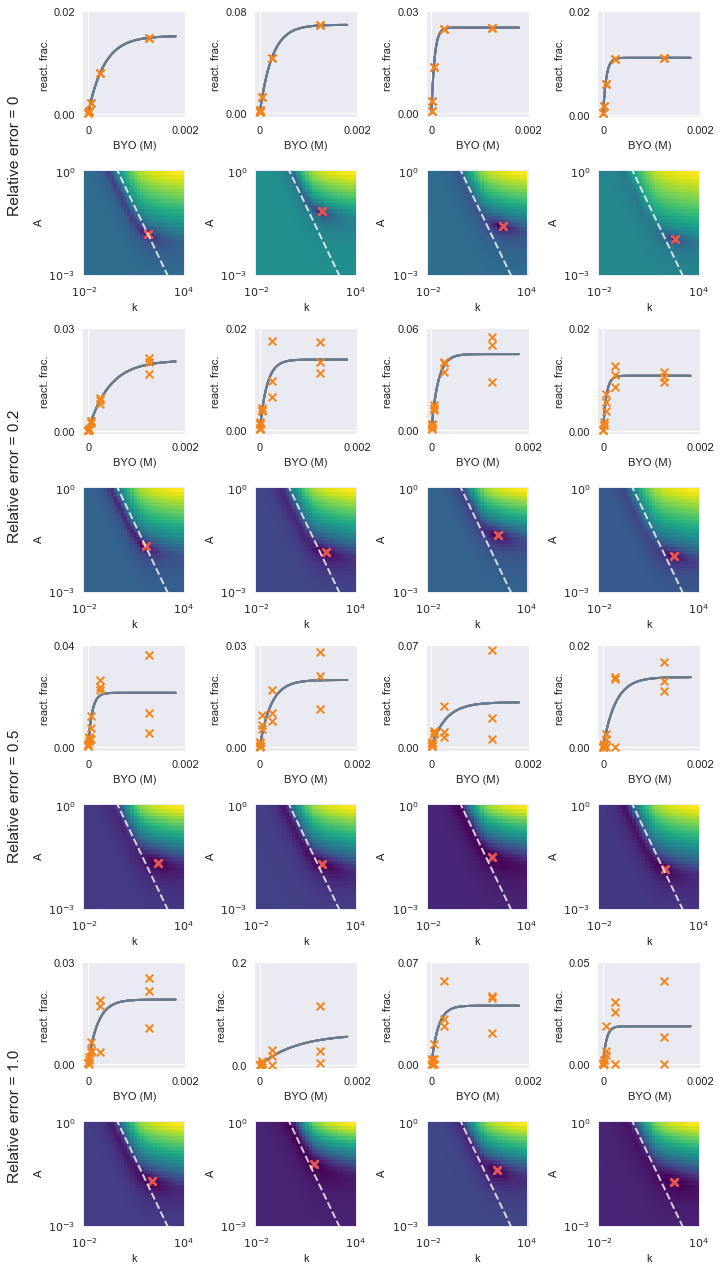

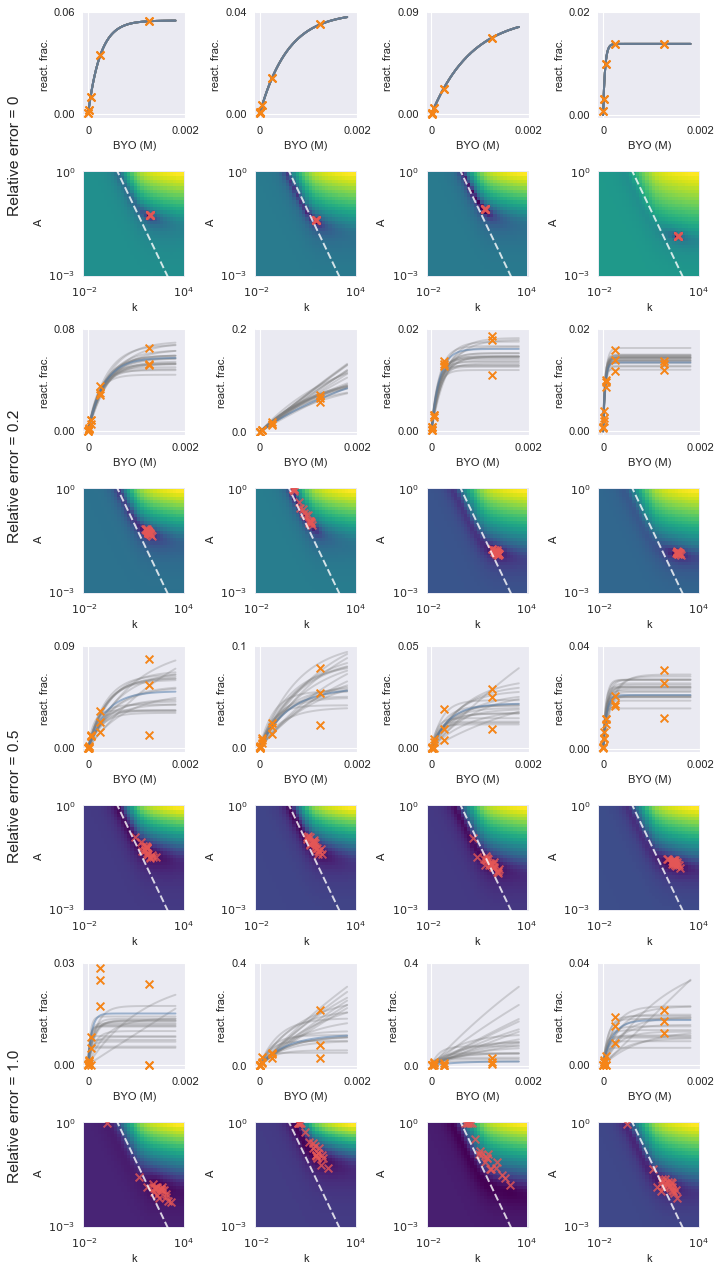

--------------------Region 6--------------------


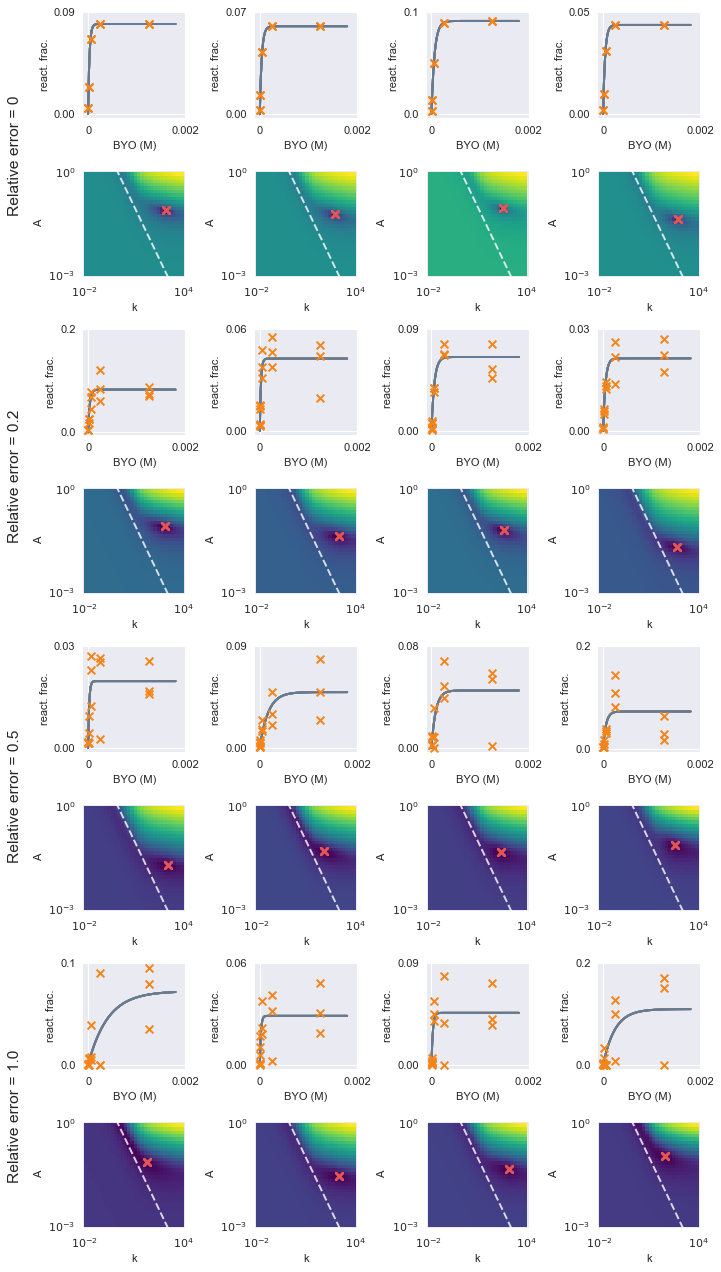

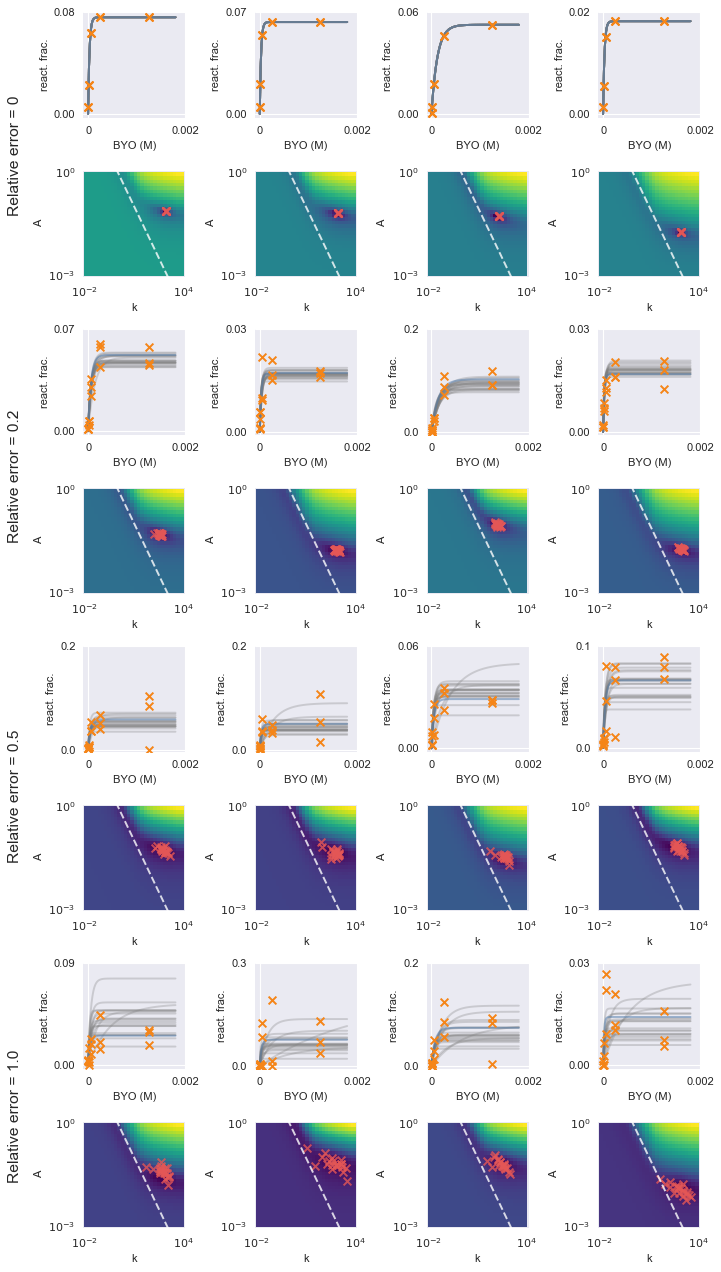

In [7]:
load_simu_react_frac()

for ix, region in enumerate(get_regions(func=True)):
    print('-' * 20 + f'Region {ix + 1}' + '-' * 20)
    seq_list = simu_react_frac_example_curves_by_region(
        exps=simu_react_frac, seq_filter_fn=region, n_example=4,
        fontsize=10, single_figsize=2, curve_type='conv',
        heatmap_resolution=30
    )
    fig = plt.gcf()
    fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s{ix + 4}-a.pdf', dpi=600, bbox_inches='tight')
    seq_list = simu_react_frac_example_curves_by_region(
        exps=simu_react_frac, seq_filter_fn=region, n_example=4,
        fontsize=10, single_figsize=2, curve_type='bs',
        heatmap_resolution=30
    )
    fig = plt.gcf()
    fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s{ix + 4}-b.pdf', dpi=600, bbox_inches='tight')
    plt.show()

## Figure S10: compare the distribution of metrics for model identifiability

In [5]:
def metric_value_dist(exp, metric, vrange=None, label=None, bins=50, log=False,
                      ax=None, legend=False, conds=None, conds_formatter='cond {}', 
                      fontsize=12):
    """Plot a single histogram of sequence metric distribution, separated by conditions if provided"""
    from k_seq.utility import plot_tools
        
    metric_val = exp.get_metric_values(metric=metric, finite_only=True)
    if vrange is None:
        vrange = np.nanmin(metric_val), np.nanmax(metric_val)
    
    bins = np.logspace(np.log10(vrange[0]), np.log10(vrange[1]), bins) if log else np.linspace(vrange[0], vrange[1], bins)
    
    ax = plot_tools.ax_none(ax)
    if conds is None:
        ax.hist(metric_val, bins=bins, alpha=0.8)
    else:
        colors = plot_tools.Presets.color_tab10(len(conds))
        ax.hist([metric_val.reindex(cond) for cond in conds],
                bins=bins, color=colors, alpha=0.5, stacked=True,
                label=[conds_formatter.format(i + 1) for i in range(len(conds))])
    
    if log:
        ax.set_xscale('log')
        
    ax.set_xlim(vrange[0] * 0.9, vrange[1] * 1.1)
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], ylim[1] * 1.3)
    if label is not None:
        ax.set_xlabel(label, fontsize=fontsize)
    
    if legend:
        ax.legend(ncol=2)
    
    return metric_val

def single_metric_value_dist_compare(exps, metric, label,
                                     bins=50, vrange=None, axes=None, 
                                     y_label=True, legend=True, fontsize=12):
    """Plot the histogram for metric value distribution, compare different results"""
    
    if vrange is None:
        vmin, vmax = 0, 0
        for exp in exps.values():
            metric_val = exp.get_metric_values(metric=metric, finite_only=True)
            metric_val = metric_val[np.isfinite(metric_val)]
            vmin = vmin if vmin < np.nanmin(metric_val) else np.nanmin(metric_val)
            vmax = vmax if vmax > np.nanmax(metric_val) else np.nanmax(metric_val)
    else:
        vmin, vmax = vrange
    
    if axes is None:
        fig, axes = plt.subplots(len(sep_map), 1, figsize=(6, 1.5 * len(sep_map)), 
                                 sharex='col')
    else:
        fig = plt.gcf()
    for ax, (name, exp) in zip(axes, exps.items()):
        metric_value_dist(exp=exp, metric=metric, vrange=(vmin, vmax),
                          label=None, bins=bins, conds_formatter='Region {}',
                          ax=ax, conds=get_regions(exp), fontsize=fontsize)
        ax.text(s=name, x=0.95, y=0.95, ha='right', va='top', fontsize=fontsize - 2, alpha=0.8,
                transform=ax.transAxes)
        ax.tick_params(labelsize=fontsize - 2)
    
    axes[-1].set_xlabel(label, fontsize=fontsize)
    if y_label:
        fig.text(s='Number of sequences', x=0.08, y=0.5, va='center', ha='right',
                 fontsize=fontsize, rotation=90)
    if legend:
        axes[-1].legend(loc=(1.05, 0), fontsize=fontsize)
#     plt.tight_layout()

def metrics_value_dist_compare(exps, metrics, labels, vrange=None, bins=50, fontsize=12):
    """Compare the metric distribution across different metrics"""
    
    fig, axes = plt.subplots(len(exps), len(metrics), 
                             figsize=(4 * len(metrics), 1.5 * len(exps)), sharex='col')
    for metric, label, ax in zip(metrics, labels, np.transpose(axes)):
        single_metric_value_dist_compare(exps, metric, label=label,
                                         bins=bins, axes=ax,
                                         legend=(metric == metrics[-1]), 
                                         y_label=(metric == metrics[0]),
                                         fontsize=fontsize)

INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr0...
INFO:root:'seqs.tar.gz' found


loading simu_react_frac


INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr02...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr05...
INFO:root:'seqs.tar.gz' found
INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/simu-react-frac/extended-relErr10...
INFO:root:'seqs.tar.gz' found


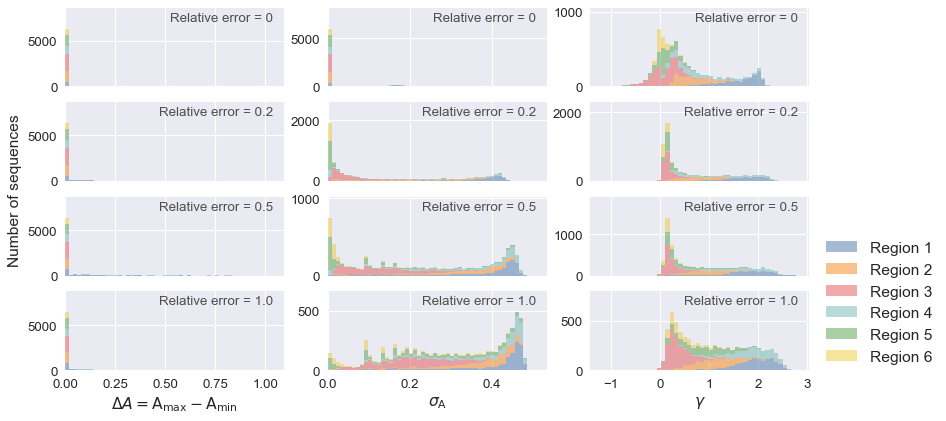

In [18]:
load_simu_react_frac()

from k_seq.estimate.model_ident import gamma

metrics_value_dist_compare(
    exps=simu_react_frac, metrics=['conv_A_range', 'bs_A_std', gamma],
                           labels=['$\\Delta A = \\mathrm{{A}}_\\mathrm{{max}} - \\mathrm{{A}}_\\mathrm{{min}}$',
                                   '$\sigma_{{\mathrm{{A}}}}$',
                                   '$\\gamma$'], fontsize=14)

fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s10.pdf', bbox_inches='tight')

## Figure S11: distribution of model identifiability metrics and sample curves for sequences within different range of metric scores

In [6]:
def get_metric_values(exp, metric):
    if isinstance(metric, str):
        metric_val = exp.summary[metric]
    elif callable(metric):
        metric_val = exp.summary.apply(metric, axis=1)
    else:
        raise TypeError()
        
    return metric_val

def get_FitResult(seq, result):
    return result.get_FitResult(seq)

def sample_curves(result, metric, sample_bins, n_example=10, 
                  figsize=None, fontsize=12, single_figsize=1.8, seed=23, save_to=None,
                  heatmap_resolution=100,
                 ):
    """Plot example fitting curves and loss function map for sequence fitting results and conditioned provided in exps"""
    from k_seq.utility import plot_tools, mp_job
    from functools import partial
    
    n_cond = len(sample_bins) - 1
    
    fig, axes = plt.subplots(2 * n_cond, n_example, 
                             figsize=(single_figsize * n_example * 1.1, single_figsize * 2 * n_cond))
    
    work_fn = partial(get_FitResult, result=result)
    
    for ix, start in enumerate(sample_bins[:-1]):
        seq_list = result.summary[(result.summary[metric] > start) & (result.summary[metric] < sample_bins[ix + 1])].index
        
        if len(seq_list) > n_example:
            np.random.seed(seed)
            seq_list = np.random.choice(seq_list, size=n_example, replace=False)
        
        fit_results = mp_job(work_fn, list(seq_list), use_fork=True)
            
        for fit_result, ax in zip(fit_results, axes[ix * 2]):
            fit_result.plot_fitting_curves(plot_on='bootstrap', ax=ax, x_label='BYO (M)', 
                                           x_lim=(-0.0003, 0.002),
                                           fontsize=fontsize, y_label='react. frac.')
            from math import ceil
            y_lim = ax.get_ylim()
            digits = int(np.log10(y_lim[1]))
            y_top = ceil(y_lim[1] / 10 ** digits * 10) * 10 ** digits / 10
            
            ax.set_ylim((y_lim[0], y_top))
            ax.set_yticks([0, y_top])
            ax.set_xticks([0, 0.002])
            ax.set_xticklabels(['0', '0.002'])
            
            
        for fit_result, ax in zip(fit_results, axes[ix * 2 + 1]):
            fit_result.plot_loss_heatmap(
                plot_on='bootstrap', ax=ax,
                colorbar=False,
                fontsize=fontsize, add_lines=[1],
                tick_num=2,
                resolution=heatmap_resolution
            )
            ax.set_xticks([0, heatmap_resolution])
            ax.set_xticklabels(['$10^{-2}$', '$10^4$'])
            ax.set_yticks([0, heatmap_resolution])
            ax.set_yticklabels(['$10^{-3}$', '$10^{0}$'])

            
        fig.text(s=f"{start:.2f} ~ {sample_bins[ix + 1]:.2f}", x=0, y=1 - (ix * 2 + 1) / (n_cond * 2), ha='right', va='center', fontsize=14, rotation=90)

    plt.tight_layout()
    return fig

INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/experimental/byo-variant/double-mutants_bs-100...
INFO:root:'seqs.tar.gz' found


loading variant_pool_res_double_mutants


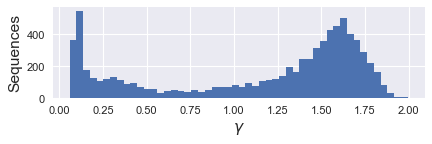

INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 4/4 [00:00<00:00,  4.52it/s]
INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 4/4 [00:00<00:00,  4.92it/s]
INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 4/4 [00:00<00:00,  5.45it/s]
INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 4/4 [00:00<00:00,  5.79it/s]


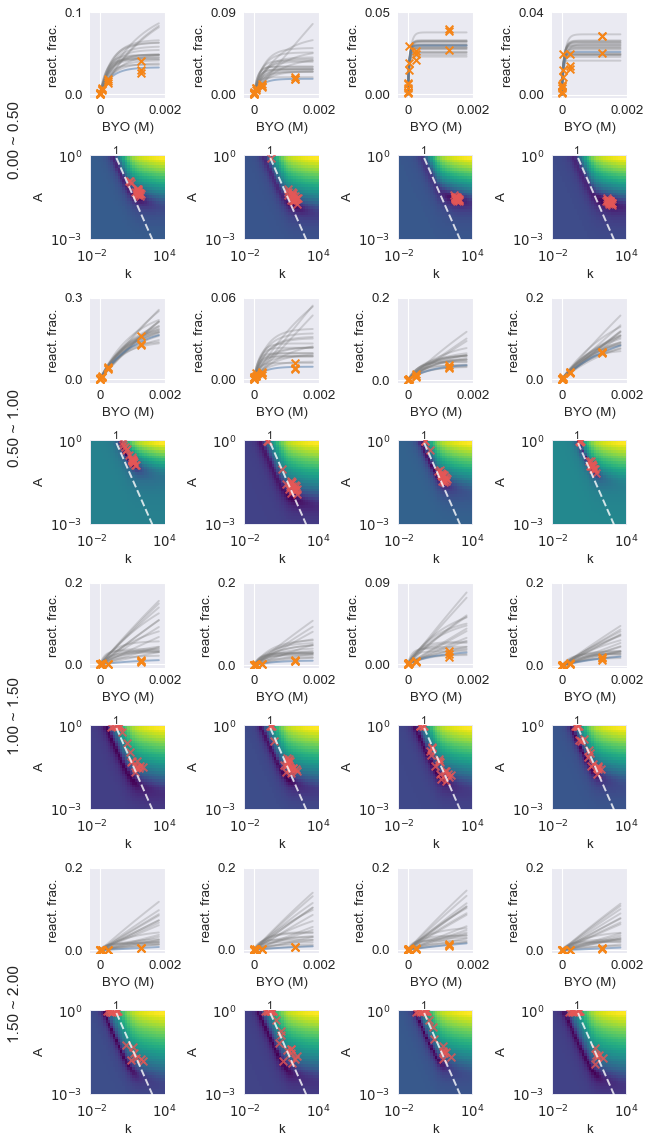

In [11]:
load_variant_pool_res_double_mutants()

# gamma
# histogram
fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
ax.hist(variant_pool_res_double_mutants.summary['gamma'], bins=50)
ax.set_xlabel('$\gamma$', fontsize=14)
ax.set_ylabel('Sequences', fontsize=14)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s11-a.pdf', bbox_inches='tight')
plt.show()

# example curves
fig = sample_curves(
    result=variant_pool_res_double_mutants, metric='gamma',
    sample_bins= [0, 0.5, 1.0, 1.5, 2], n_example=4, 
    figsize=None, fontsize=12, single_figsize=1.8, save_to=None,
    heatmap_resolution=30
)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s11-c.pdf', bbox_inches='tight', dpi=600)

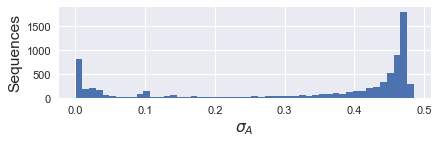

INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 4/4 [00:00<00:00,  5.05it/s]
INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 4/4 [00:00<00:00,  5.26it/s]
INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 4/4 [00:00<00:00,  5.06it/s]
INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


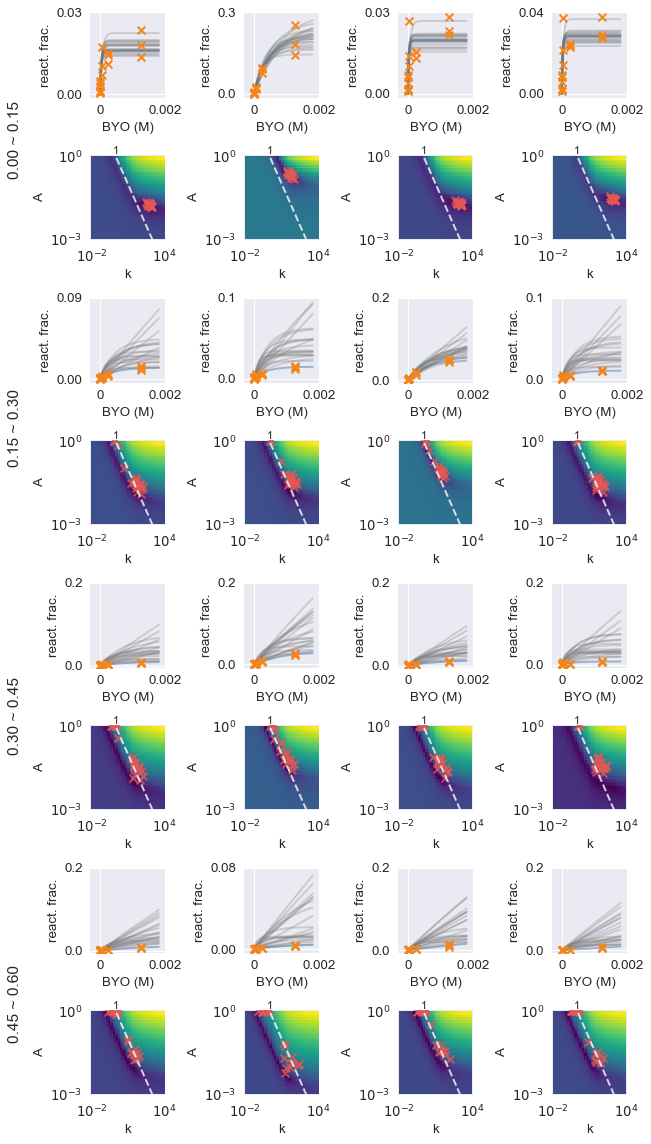

In [12]:
# sigma

# histogram 
fig, ax = plt.subplots(1, 1, figsize=(6, 1.5))
ax.hist(variant_pool_res_double_mutants.summary['bs_A_std'], bins=50)
ax.set_xlabel('$\sigma_{A}$', fontsize=14)
ax.set_ylabel('Sequences', fontsize=14)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s11-b.pdf', bbox_inches='tight')
plt.show()


fig = sample_curves(
    result=variant_pool_res_double_mutants, metric='bs_A_std', sample_bins= [0, 0.15, 0.3, 0.45, 0.6], n_example=4, 
    figsize=None, fontsize=12, single_figsize=1.8, save_to=None,
    heatmap_resolution=30
)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s11-d.pdf', bbox_inches='tight', dpi=600)

## Figure S12: alignment of two model identifiability metrics in sequences from BYO-variant pool

variant_pool found
variant_pool_res found
variant_pool_res_double_mutants found
Spearman correlation of two metrics: 0.945 (p-value: 0.0)


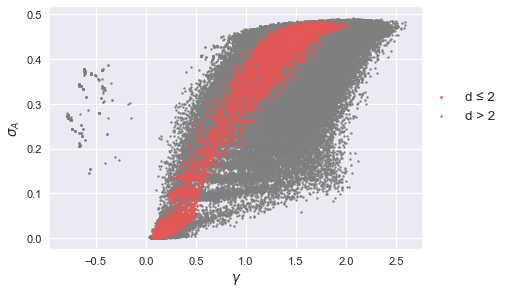

In [13]:
load_variant_pool()
load_variant_pool_res_double_mutants()

variant_pool_res.summary.loc[variant_pool_res.summary.index.isin(variant_pool_res_double_mutants.summary.index), 'Type'] = 'd ≤ 2'
variant_pool_res.summary.loc[~variant_pool_res.summary.index.isin(variant_pool_res_double_mutants.summary.index), 'Type'] = 'd > 2'


# Calculate spearman r for sequences within double mutants
from scipy import stats
gamma = variant_pool_res.summary.loc[variant_pool_res.summary['Type'] == 'd ≤ 2', 'gamma']
sigma_A = variant_pool_res.summary.loc[variant_pool_res.summary['Type'] == 'd ≤ 2', 'bs_A_std']
spearman_r = stats.spearmanr(gamma[~gamma.isna()], sigma_A[~sigma_A.isna()])
print(f"Spearman correlation of two metrics: {spearman_r[0]:.3f} (p-value: {spearman_r[1]})")

# plot scatter alignment
fig, ax = plt.subplots(1, 1, figsize=(6, 4))                                    
ax.scatter(
    variant_pool_res.summary.loc[variant_pool_res.summary['Type'] == 'd ≤ 2', 'gamma'],
    variant_pool_res.summary.loc[variant_pool_res.summary['Type'] == 'd ≤ 2', 'bs_A_std'],
    alpha=1, s=5, color='#E45756', label = 'd ≤ 2', zorder=5
)

ax.scatter(
    variant_pool_res.summary.loc[variant_pool_res.summary['Type'] == 'd > 2', 'gamma'],
    variant_pool_res.summary.loc[variant_pool_res.summary['Type'] == 'd > 2', 'bs_A_std'],
    alpha=1, s=3, color='#7F7F7F', label = 'd > 2', zorder=1
)

ax.set_xlabel('$\gamma$', fontsize=12)
ax.set_ylabel('$\sigma_A$', fontsize=12)

ax.legend(loc=(1, 0.5), fontsize=12)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s12.png', dpi=600, bbox_inches='tight')
plt.show()

## Figure S13 & Table S3: DNA sequencing reads processing and the categorization of analyzable/non-analyzed sequences

In [7]:
from k_seq.utility import file_tools
from k_seq.data import filters

def rename_res(name):
    """Rename results loaded from raw reads and samples as
    A1/d-A1_S1 --> 1250 uM-1
    ...
    R/R0 --> Unreacted
    """
    
    if len(name) > 2:
        name = name.split('_')[0].split('-')[-1]
    
    if 'R' in name:
        return 'Unreacted'
    else:
        concen_mapper = {
            'A': '1250',
            'B': '250',
            'C': '50',
            'D': '10',
            'E': '2'
        }
        return "{} μM-{}".format(concen_mapper[name[0]], name[1])

def raw_read_counts(reads_tsv):
    """Load raw read count"""
    # add raw reads
    raw_reads = pd.read_csv(reads_tsv, sep='\t')
    sample_reads = raw_reads[raw_reads['R'] == 1].groupby('file').sum()
    raw_reads_fw = sample_reads['reads'].rename(rename_res)
    sample_reads = raw_reads[raw_reads['R'] == 2].groupby('file').sum()
    raw_reads_bw = sample_reads['reads'].rename(rename_res)
    
    raw_reads_fw.index.name = 'sample'
    raw_reads_bw.index.name = 'sample'
    raw_reads_fw.name = 'Forward'
    raw_reads_bw.name = 'Reverse'
    
    try:
        pd.testing.assert_series_equal(raw_reads_fw, raw_reads_bw, check_names=False)
        print('Num of forward reads == Num of reverse reads')
    except:
        print('Num of forward reads != Num of reverse reads')
    
    return pd.concat([raw_reads_fw, raw_reads_bw], axis=1)

def get_total_and_unique(table):
    """Survey the total the unique molecules in a table"""
    return table.sum(axis=0).rename(rename_res).astype(int), (table > 0).sum(axis=0).rename(rename_res).astype(int)

In [16]:
# load data
unique = pd.DataFrame()
counts = raw_read_counts(f'{PAPER_DATA_DIR}/data/byo-variant/sample_reads.tsv')

load_variant_pool()    
counts['Joined'], unique['Joined'] = get_total_and_unique(variant_pool.table.original)

# Spike-in filter
spike_in_filter = filters.SpikeInFilter(target=variant_pool)
counts['Spike-in removed'], unique['Spike-in removed'] = get_total_and_unique(spike_in_filter(variant_pool.table.original))

# Non-21 nt filter + non-ambiguity (N) filter
non_21_filter = filters.SeqLengthFilter(min_len=21, max_len=21)
no_ambiguity_filter = filters.NoAmbiguityFilter()
counts['Spike-in + non-21nt removed'], unique['Spike-in + non-21nt removed'] = get_total_and_unique(no_ambiguity_filter(non_21_filter(
    spike_in_filter(variant_pool.table.original)
)))

counts['Filtered'], unique['Filtered'] = get_total_and_unique(variant_pool.table.filtered)
counts['Analyzable'], unique['Analyzable'] = get_total_and_unique(variant_pool.table.filtered.loc[variant_pool.table.reacted_frac_qpcr.index])

counts

Num of forward reads == Num of reverse reads
variant_pool found
variant_pool_res found


,Forward,Reverse,Joined,Spike-in removed,Spike-in + non-21nt removed,Filtered,Analyzable
sample,,,,,,,
1250 μM-1,13213764,13213764,12004474,11815259,11506274,11506274,11438244
1250 μM-2,12894984,12894984,11752226,11603611,11316297,11316297,11258274
1250 μM-3,27374060,27374060,24822838,24630429,24015944,24015944,23908610
250 μM-1,12161566,12161566,11116634,10961198,10755820,10755820,10730550
250 μM-2,13689983,13689983,12552203,12371137,12147620,12147620,12120934
250 μM-3,12424566,12424566,11352810,11183163,10971785,10971785,10949518
50 μM-1,9798829,9798829,8935891,8814042,8632530,8632530,8583785
50 μM-2,10452190,10452190,9571053,9374026,9211942,9211942,9184388
50 μM-3,11582875,11582875,10536759,10362471,10192232,10192232,10161795


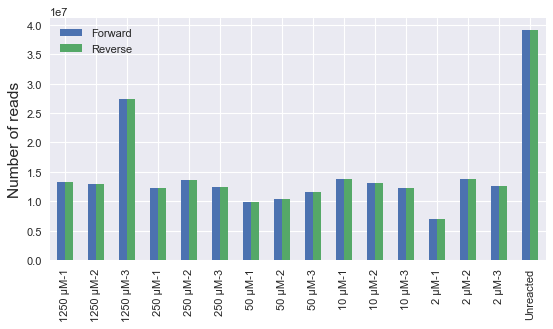

Unreacted samples: 39,151,684
Reacted samples: 13,057,929 ± 4,359,249


In [17]:
# Number of raw reads
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax = counts[['Forward', 'Reverse']].plot(kind='bar', ax=ax)
ax.set_ylabel('Number of reads', fontsize=14)
ax.set_xlabel('')
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s13-a.pdf', bbox_inches='tight')
plt.show()
    
print(f"Unreacted samples: {counts.loc['Unreacted', 'Forward']:,}")
print(f"Reacted samples: {counts['Forward'].drop('Unreacted').mean():,.0f} ± {counts['Forward'].drop('Unreacted').std():,.0f}")
      

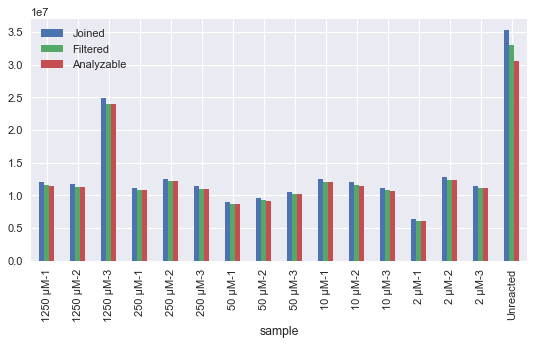

variant_pool found
variant_pool_res found
Analyzable sequences: 764,756


In [18]:
# Number of reads pass each step 

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
stages = ['Joined', 'Filtered', 'Analyzable']
counts[stages].plot(kind='bar', ax=ax)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s13-b.pdf', bbox_inches='tight')
plt.show()

load_variant_pool()
print(f'Analyzable sequences: {variant_pool.table.reacted_frac_qpcr.shape[0]:,d}')

Joined
- Total reads: 91.3% (0.5%)
- Unreacted samples: 90.0%
- Reacted samples: 91.3% (0.4%)
Filtered
- Total reads: 87.9% (1.1%)
- Unreacted samples: 84.1%
- Reacted samples: 88.2% (0.5%)
Analyzable
- Total reads: 87.1% (2.5%)
- Unreacted samples: 77.9%
- Reacted samples: 87.7% (0.6%)


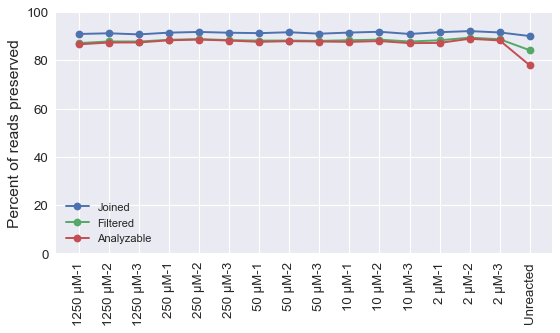

In [19]:
stages = ['Joined', 'Filtered', 'Analyzable']
read_pct = counts[stages].divide(counts['Forward'], axis=0) * 100

fig, ax = plt.subplots(1, 1, figsize=[8, 4])
pos = np.arange(read_pct.shape[0]) * (len(stages) + 2)

# plot each stage
for ix, stage in enumerate(stages):
    ax.plot(pos, read_pct[stage], marker='o', zorder=10, label=stage)
    
    # print summary
    print(stage)
    print(f"- Total reads: {read_pct[stage].mean():.1f}% ({read_pct[stage].std():.1f}%)")
    print(f"- Unreacted samples: {read_pct.loc['Unreacted', stage]:.1f}%")
    print(f"- Reacted samples: {read_pct[stage].drop('Unreacted').mean():.1f}% ({read_pct[stage].drop('Unreacted').std():.1f}%)")
    
ax.set_ylabel('Percent of reads preserved', fontsize=14)
ax.tick_params(labelsize=12)
ax.set_ylim([0, 100])
ax.set_xticks(pos)
ax.legend()
ax.set_xticklabels(read_pct.index, fontsize=12, rotation=90)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s13-c.pdf', bbox_inches='tight')
plt.show()
          
del read_pct

In [20]:
# differential fraction failed
stages = ['Joined', 'Spike-in removed', 'Spike-in + non-21nt removed', 'Analyzable']
diff_pct = -counts[['Forward'] + stages].divide(counts['Forward'], axis=0).diff(axis=1) * 100

print('Percent of reads failed at each step:')
for ix, stage in enumerate(stages):
    print(stage)
    print(f"- Total reads: {diff_pct[stage].mean():.1f}% ({diff_pct[stage].std():.1f}%)")
    print(f"- Unreacted samples: {diff_pct.loc['Unreacted', stage]:.1f}%")
    print(f"- Reacted samples: {diff_pct[stage].drop('Unreacted').mean():.1f}% ({diff_pct[stage].drop('Unreacted').std():.1f}%)")

Percent of reads failed at each step:
Joined
- Total reads: 8.7% (0.5%)
- Unreacted samples: 10.0%
- Reacted samples: 8.7% (0.4%)
Spike-in removed
- Total reads: 1.2% (0.3%)
- Unreacted samples: 0.5%
- Reacted samples: 1.2% (0.3%)
Spike-in + non-21nt removed
- Total reads: 2.1% (0.9%)
- Unreacted samples: 5.4%
- Reacted samples: 1.9% (0.3%)
Analyzable
- Total reads: 0.8% (1.5%)
- Unreacted samples: 6.2%
- Reacted samples: 0.5% (0.2%)


In [21]:
# sequences present in the reacted samples but not in the unreacted samples
only_reacted = variant_pool.table.filtered.loc[variant_pool.table.filtered['R0'] == 0]
only_reacted_mean_counts = only_reacted.drop(columns='R0').mean(axis=1)
only_reacted_mean_counts.sort_values(ascending=False)

CCAGGTTTCAAACAATCGGTC    3.600000
TCAGCCTTCAAACAATCGGTC    2.933333
ATAGGCTTCAAGCAATCGGTC    2.733333
GCCAACTTCAAACAATCGGTC    2.666667
CCCGGGTTCAAGCAATCGGTC    2.666667
                           ...   
ATTTCAATGTTCATCGTGTGA    0.066667
ATTTCAATTGTCCTCGGGTGA    0.066667
ATTTCACAGGTAATCCAGTGA    0.066667
ATTTCACAGGTCCCCAAGTGA    0.066667
ATTACCCTAGTCCTCAAATGA    0.066667
Length: 716277, dtype: float64

In [22]:
# 6.2% sequences in the unreacted samples but not in the reacted sample
only_unreacted = variant_pool.table.filtered.loc[variant_pool.table.filtered.drop(columns='R0').sum(axis=1) == 0]['R0']
only_unreacted = pd.concat([only_unreacted, variant_pool.pool_peaks_merged.dist_to_center.loc[only_unreacted.index]], axis=1).rename(columns={0: 'hamming'})
only_unreacted.groupby('hamming').count()


,R0
hamming,
3,153
4,725546
5,805301
6,220753
7,46202
8,7995
9,1446
10,593
11,463


## Figure S14: expected counts in variant pools

In [23]:
from k_seq.data import variant_pool as var_pool

mutation_rate_list = np.linspace(1e-2, 0.4, 50)
mutation_order_list = pd.Series(np.arange(6), index=np.arange(6))

dopedpool_tables = {
    'single_seq_fraction': pd.DataFrame(index=mutation_order_list),
    'num_of_unique_seqs': pd.DataFrame(index=mutation_order_list),
    'order_fraction': pd.DataFrame(index=mutation_order_list),
    'seq_counts_in_10M': pd.DataFrame(index=mutation_order_list)
}

for mutation_rate in mutation_rate_list:
    from functools import partial    
    dopedpool_tables['single_seq_fraction'][mutation_rate] = mutation_order_list.apply(partial(var_pool.d_mutant_fraction, mutation_rate=mutation_rate))
    dopedpool_tables['num_of_unique_seqs'][mutation_rate] = mutation_order_list.apply(var_pool.num_of_seq)
    dopedpool_tables['order_fraction'][mutation_rate] = dopedpool_tables['single_seq_fraction'][mutation_rate] * dopedpool_tables['num_of_unique_seqs'][mutation_rate]
    
dopedpool_tables['seq_counts_in_10M'] = 10e6 * dopedpool_tables['single_seq_fraction']

In [24]:
print("Fraction of reads")
for order in [0, 1, 2]:
    print(f"d = {order}: {var_pool.d_mutant_fraction(order, 0.09)}")

Fraction of reads
d = 0: 0.1379968708756601
d = 1: 0.0045493473915052774
d = 2: 0.00014997848543423992


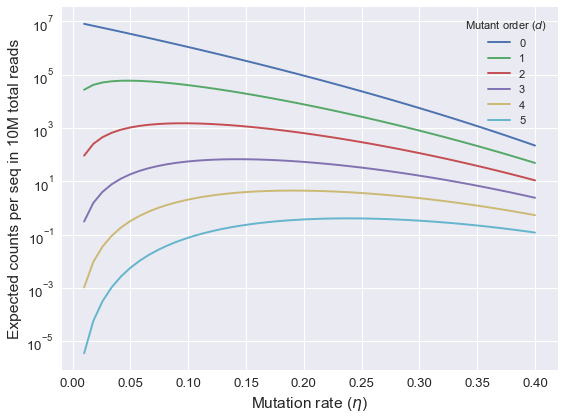

In [25]:
fig, ax = plt.subplots(1, 1, figsize=[8, 6])
dopedpool_tables['seq_counts_in_10M'].transpose().plot(ax=ax)
ax.set_yscale('log')
ax.set_xlabel('Mutation rate ($\\eta$)', fontsize=14)
ax.set_ylabel('Expected counts per seq in 10M total reads', fontsize=14)
ax.legend(title='Mutant order ($d$)', loc='upper right')
ax.tick_params(labelsize=12)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s14.pdf')
plt.show()

## Figure S15: expected fraction of reads from neighboring sequences

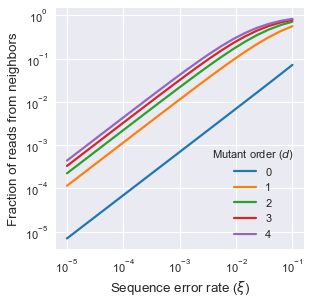

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
for d, color in zip([0, 1, 2, 3, 4], default_palette(num=5)):
    xi = np.logspace(-5, -1, 20)
    ax.plot(xi, var_pool.neighbor_effect_error(xi, d=d), label=d, lw=2, color=color)

ax.set_xlabel('Sequence error rate ($\\xi$)', fontsize=12)
ax.set_ylabel('Fraction of reads from neighbors', fontsize=12)
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend(title='Mutant order ($d$)', fontsize=10)
ax.tick_params(labelsize=10)

fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s15.pdf', bbox_inches='tight')

plt.show()

## Figure S16: correlation between k-Seq results and gel-shift results

In [27]:
k_seq_baseline = 0.124
gel_shift_baseline = 0.645

def r_s(param):
    return param[0] * param[1] / gel_shift_baseline

def kA(param):
    return param[0] * param[1]
    
def fit_seq(seq, gel_shift_data, return_full=False):
    """Fit the gel-shift data with 100 bootstraps"""
    from k_seq.estimate.least_squares import SingleFitter
    from k_seq.model.kinetic import BYOModel
    seq_data = gel_shift_data[gel_shift_data.index == seq].melt().rename(columns={'variable': 'x', 'value': 'y'})
    seq_data = seq_data[~seq_data.isna().any(axis=1)].astype(float) # exclude missing data
    
    # bootstrap fit
    
    fitter = SingleFitter(x_data=seq_data['x'], y_data=seq_data['y'],
                          x_label='BYO concentration', y_label='reacted fraction',
                          model=BYOModel.reacted_frac(broadcast=False),
                          bounds=([0, 0], [np.inf, 1]), metrics={'kA': kA, 'r_s': r_s}, name=seq,
                          bootstrap_num=100, bs_method='rel_res', bs_record_num=20)
    fitter.fit(bootstrap=True, point_estimate=True)
    
    if return_full:
        return fitter
    else:
        return fitter.results.to_series()

from k_seq.utility import mp_job

seq_name_mapper = pd.Series({
    'S-2.1-a':  'ATTACCCTGGTCATCGAGTGA',
    'S-2.1-t':  'ATTACCCTGGTCATCGAGTGT',
    'S-1A.1-a': 'CTACTTCAAACAATCGGTCTG',
    'S-1B.1-a': 'CCACACTTCAAGCAATCGGTC',
    'S-1B.2-a': 'CCGCTTCAAGCAATCGGTCGC',
    'S-1B.3-a': 'CCGAGTTTCAAGCAATCGGTC',
    'S-3.1-a':  'AAGTTTGCTAATAGTCGCAAG',
    'S-2.2-a':  'ATTCACCTAGGTCATCGGGTG',
    'S-1A.1-n': 'CTCTTCAAACAATCGGTCTTC',
    'S-1C.1-a': 'CTCTTCAATAATCGGTTGCGT',
})

In [35]:
np.random.seed(23) # for resampling repeatability

gel_shift_data = pd.read_csv(f'{PAPER_DATA_DIR}/results/experimental/gel-shift-reacted-frac.csv').set_index('seq')
gel_shift_results = pd.DataFrame(mp_job(fit_seq, gel_shift_data.index.unique(), gel_shift_data=gel_shift_data, use_fork=True))
gel_shift_results = gel_shift_results.reset_index().rename(columns={'index':'seq'})
gel_shift_results.index = gel_shift_results['seq'].map(seq_name_mapper)
gel_shift_results[['seq', 'kA', 'r_s', 'bs_r_s_std']]

INFO:root:Using fork mode - this could be unsafe for subprocesses
100%|██████████| 10/10 [00:03<00:00,  2.86it/s]


,seq,kA,r_s,bs_r_s_std
seq,,,,
ATTACCCTGGTCATCGAGTGA,S-2.1-a,705.689351,1094.092017,180.723111
ATTACCCTGGTCATCGAGTGT,S-2.1-t,545.276868,845.390493,289.015443
CTACTTCAAACAATCGGTCTG,S-1A.1-a,214.194764,332.084906,201.737150
CCACACTTCAAGCAATCGGTC,S-1B.1-a,148.902697,230.856895,88.471602
CCGCTTCAAGCAATCGGTCGC,S-1B.2-a,78.624186,121.897963,41.637845
CCGAGTTTCAAGCAATCGGTC,S-1B.3-a,139.357472,216.058096,35.446458
AAGTTTGCTAATAGTCGCAAG,S-3.1-a,139.787513,216.724826,135.264013
ATTCACCTAGGTCATCGGGTG,S-2.2-a,143.457445,222.414643,60.246368
CTCTTCAAACAATCGGTCTTC,S-1A.1-n,182.886457,283.544894,66.778402


In [29]:
# sequences found in the variant pool
load_variant_pool()
variant_pool_res.summary.reindex(gel_shift_results.index)['kA']

variant_pool found
variant_pool_res found


seq
ATTACCCTGGTCATCGAGTGA    129.465903
ATTACCCTGGTCATCGAGTGT    191.143850
CTACTTCAAACAATCGGTCTG     66.313237
CCACACTTCAAGCAATCGGTC     54.608466
CCGCTTCAAGCAATCGGTCGC           NaN
CCGAGTTTCAAGCAATCGGTC     85.448201
AAGTTTGCTAATAGTCGCAAG     22.149679
ATTCACCTAGGTCATCGGGTG           NaN
CTCTTCAAACAATCGGTCTTC           NaN
CTCTTCAATAATCGGTTGCGT     15.310079
Name: kA, dtype: float64

In [8]:
def plot_alignment(x_data, y_data, marker_center='kA', errorbars=('bs_kA_2.5%', 'bs_kA_97.5%'),
                   marker='o', color='#4C78A8', label=None,
                   ax=None, figsize=(5, 5), **plot_kwargs):
    from k_seq.utility.plot_tools import ax_none
    
    ax = ax_none(ax, figsize)
    shared_seq = list(set(x_data.index) & set(y_data.index))
    print(f'{len(shared_seq)} sequences found in both samples')
    cols = [marker_center]
    if errorbars is not None:
        cols += list(errorbars) if isinstance(errorbars, (tuple, list)) else [errorbars]
    x_data = x_data.loc[shared_seq, cols]
    y_data = y_data.loc[shared_seq, cols]
    
    if errorbars is None:
        ax.scatter(x=x_data[marker_center], y=y_data[marker_center],
                   marker=marker, color=color, label=label, **plot_kwargs)
    
    else:
        if isinstance(errorbars, (tuple, list)):
            xerr = (x_data[marker_center] - x_data[errorbars[0]], x_data[errorbars[1]] - x_data[marker_center])
            yerr = (y_data[marker_center] - y_data[errorbars[0]], y_data[errorbars[1]] - y_data[marker_center])
        else:
            xerr = x_data[errorbars]
            yerr = y_data[errorbars]
        
        plot_kwargs = {**dict(capsize=4, capthick=1.5), **plot_kwargs}
        ax.errorbar(
            x=x_data.loc[shared_seq, marker_center], y=y_data.loc[shared_seq, marker_center],
            xerr=xerr, yerr=yerr,
            fmt=marker, color=color, label=label, **plot_kwargs
        )
        
    from scipy.stats import pearsonr, spearmanr
    pr = pearsonr(x_data[marker_center].astype(float),
                  y_data[marker_center].astype(float))
    print(f"Pearson's r: {pr[0]:.3f} (p-val: {pr[1]:.2e})")
    spr = spearmanr(x_data[marker_center].astype(float),
                    y_data[marker_center].astype(float))
    print(f"Spearman's rho: {spr[0]:.3f} (p-val: {spr[1]:.2e})")
        
    return ax, dict(x_data=x_data, y_data=y_data)

enriched_pool found
enriched_pool_res found
variant_pool found
variant_pool_res found
---------- variant pool vs. gel shift -------------
7 sequences found in both samples
Pearson's r: 0.835 (p-val: 1.94e-02)
Spearman's rho: 0.750 (p-val: 5.22e-02)
---------- enriched pool vs. gel shift -------------
10 sequences found in both samples
Pearson's r: 0.967 (p-val: 5.16e-06)
Spearman's rho: 0.697 (p-val: 2.51e-02)


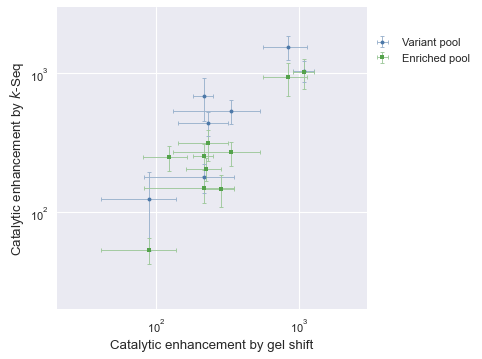

---------- variant pool vs. enriched pool -------------
Comparing 7 shared in the variant pool and the enriched pool
Pearson's r: 0.904 (p-val: 5.163e-03)
Spearman's rho: 0.821 (p-val: 2.345e-02)


In [36]:
load_enriched_pool()
load_variant_pool()

errorbar_fmt = dict(
    elinewidth=0.8,
    capsize=2,
    capthick=0.8,
    marker='o',
    color='#4C78A8',
    ecolor='#64B5F6',
    markersize=3.5
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

print('---------- variant pool vs. gel shift -------------')
k_seq_results = variant_pool_res.summary
k_seq_results['r_s'] = k_seq_results['kA'] / k_seq_baseline
k_seq_results['bs_r_s_std'] = k_seq_results['bs_kA_std'] / k_seq_baseline

_, variant_pool_data = plot_alignment(
    x_data=gel_shift_results, y_data=k_seq_results,
    marker_center='r_s', errorbars='bs_r_s_std',
    label='Variant pool', ax=ax, 
    **{**errorbar_fmt, **dict(color='#4C78A8', ecolor='#99B1CC', marker='o')}
)


print('---------- enriched pool vs. gel shift -------------')
k_seq_results = enriched_pool_res.summary
k_seq_results['r_s'] = k_seq_results['kA'] / k_seq_baseline
k_seq_results['bs_r_s_std'] = k_seq_results['bs_kA_std'] / k_seq_baseline

_, enriched_pool_data = plot_alignment(
    x_data=gel_shift_results, y_data=k_seq_results,
    marker_center='r_s', errorbars='bs_r_s_std',
    label='Enriched pool', ax=ax, 
    **{**errorbar_fmt, **dict(color='#54A24B', ecolor='#9DC89A', marker='s')}
)
ax.set_xlabel('Catalytic enhancement by gel shift', fontsize=12)
ax.set_ylabel('Catalytic enhancement by $k$-Seq', fontsize=12)        
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(20, 3000)
ax.set_ylim(20, 3000)
ax.legend(loc=(1, 0.8))

plt.show()

print('---------- variant pool vs. enriched pool -------------')
from scipy.stats import pearsonr, spearmanr
shared_seq = list(set(variant_pool_data['y_data'].index) & set(enriched_pool_data['y_data'].index))
print(f'Comparing {len(shared_seq)} shared in the variant pool and the enriched pool')

pr = pearsonr(variant_pool_res.summary.loc[shared_seq, 'r_s'],
              enriched_pool_res.summary.loc[shared_seq, 'r_s'])
print(f"Pearson's r: {pr[0]:.3f} (p-val: {pr[1]:.3e})")

spr = spearmanr(variant_pool_res.summary.loc[shared_seq, 'r_s'],
                enriched_pool_res.summary.loc[shared_seq, 'r_s'])
print(f"Spearman's rho: {spr[0]:.3f} (p-val: {spr[1]:.3e})")


fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s16.pdf', bbox_inches='tight')

plt.show()


## Figure S17: uncertainty accuracy vs sequences with different kA

In [14]:
def uncertainty_accuracy_seq_bins(accuracy, bin_by, bin_size=25000):
    accuracy = accuracy.sort_values(by=bin_by, ascending=False)
    bin_num = int(accuracy.shape[0] / bin_size)
    acc_list = [accuracy.iloc[ix * bin_size : (ix + 1) * bin_size]['in_ci95'].mean() for ix in range(bin_num)]
    N_list = [(ix + 1) * bin_size for ix in range(bin_num)]
    return acc_list, N_list, accuracy


def plot_uncertainty_accuracy_seq_bins(result, bin_by, pred_types, 
                                       param='kA', bin_by_label=None, bin_size=25000, 
                                       ax=None, figsize=(6, 4), fontsize=12):
    
    composed = {}
    # line plot
    ax = plot_tools.ax_none(ax=ax, figsize=figsize)
    color_list = plot_tools.Presets.color_tab10(len(pred_types))
    
    if isinstance(pred_types, (list, tuple)):
        pred_types = {pred_type: pred_type for pred_type in pred_types}
    
    for (pred_type_label, pred_type), color in zip(pred_types.items(), color_list):
        acc_list, N_list, accuracy = uncertainty_accuracy_seq_bins(
            accuracy=result.get_uncertainty_accuracy(param=param, pred_type=pred_type),
            bin_by=bin_by, bin_size=bin_size
        )
        composed[pred_type_label] = np.mean(accuracy['in_ci95'])
        
        ax.plot(N_list, acc_list, '-o', markersize=5, color=color, alpha=0.5, label=pred_type_label)
    
    
    ax.set_xlabel(f'Sequences (ordered by {bin_by if bin_by_label is None else bin_by_label})',
                  fontsize=fontsize)
    ax.set_ylabel('Fraction of truth in CI-95', 
                  fontsize=fontsize)
    ax.tick_params(labelsize=fontsize - 2)
    
    xlim = ax.get_xlim()
    ax.plot(xlim, [0.95, 0.95], 'k', ls='--', alpha=0.5, zorder=1)
    ax.set_xlim(xlim[0], xlim[1])
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], 1)
    
    ax.legend()
    
    return composed, ax

simu_count found


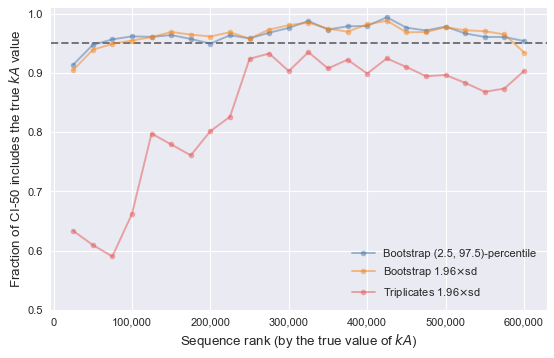

In [15]:
load_simu_count()

comp_all, ax = plot_uncertainty_accuracy_seq_bins(
    result=simu_count,
    bin_by='kA_truth', bin_by_label='kA true value',
    pred_types={'Bootstrap (2.5, 97.5)-percentile':'bs_ci95',
                "Bootstrap 1.96$\\times$sd":'bs_sd',
                "Triplicates 1.96$\\times$sd": 'rep_sd'},
    figsize=(8, 5),
    param='kA',
)
from matplotlib import ticker
ax.get_xaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)
ax.set_xlabel('Sequence rank (by the true value of $kA$)')
ax.set_ylabel('Fraction of CI-50 includes the true $kA$ value')
ax.set_ylim(0.5, 1.01)
fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s17.pdf', bbox_inches='tight')

## Figure S18: precision vs kA

In [16]:
def scatter_plot_results_on_mutation_dist(result, x, y, x_label, y_label, x_lim, y_lim, x_log=True, y_log=True, top_group_size=int(1e4), top_y_values=None, fontsize=14):
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    w_list = {'$d = 0$': lambda df: df['dist_to_center'] == 0,
              '$d = 1$': lambda df: df['dist_to_center'] == 1,
              '$d = 2$': lambda df: df['dist_to_center'] == 2,
              '$d = 3$': lambda df: df['dist_to_center'] == 3,
              '$d \geq 4$': lambda df: df['dist_to_center'] >= 4}

    color_list = plot_tools.Presets.color_tab10(len(w_list))

    for ix, ((label, filter_fn), color) in enumerate(zip(w_list.items(), color_list)):
        seq_list = result[filter_fn(result)].index
        if len(seq_list) > top_group_size:
            seq_list = seq_list.to_series().sample(top_group_size)
        x_series = result.loc[seq_list, x]
        y_series = result.loc[seq_list, y]
        if top_y_values is not None:
            y_series[y_series > top_y_values] = top_y_values
        ax.scatter(x_series, y_series,
                   marker='o', s=20 -  ix ** 2, color=color, label=label, alpha=1 - 0.15 * ix, zorder = 8 - ix)

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(x_label, fontsize=fontsize)
    ax.set_ylabel(y_label, fontsize=fontsize)
    ax.tick_params(labelsize=fontsize - 2)
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    ax.legend()

loading variant_pool


INFO:root:loading data from /Users/yuning/research/k-seq-data/submission/k-seq-dataset-archive/core-data/results/experimental/byo-variant/all-seq_bs-100...


loading variant_pool_res


INFO:root:'seqs.tar.gz' found


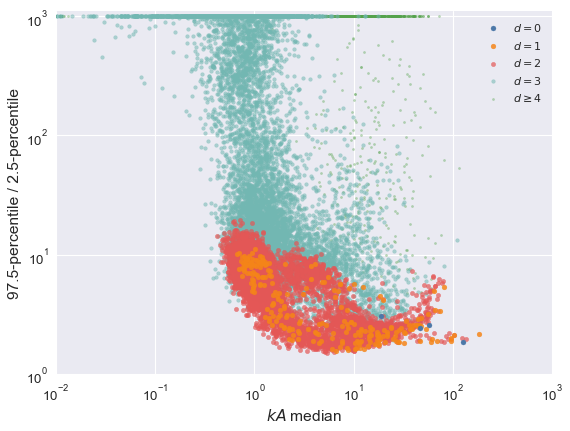

In [17]:
load_variant_pool()

variant_pool_res.summary['dist_to_center'] =  variant_pool_res.summary.index.to_series().map(variant_pool.pool_peaks_merged.dist_to_center)
variant_pool_res.summary['kA_fold_range'] = variant_pool_res.summary['bs_kA_97.5%'] / variant_pool_res.summary['bs_kA_2.5%']

scatter_plot_results_on_mutation_dist(
    result=variant_pool_res.summary, x = 'bs_kA_50%', y = 'kA_fold_range',
    x_label = '$kA$ median', y_label = '97.5-percentile / 2.5-percentile',
    x_log = True, y_log = True, x_lim = (1e-2, 1e3), y_lim = (1, 1.1e3),
    fontsize = 14, top_group_size = int(1e4), top_y_values = 1e3
)
fig = plt.gcf()
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s18.pdf', bbox_inches='tight')


## Figure S19: Streptavidin non-specific retention

In [42]:
# non-specific retention of RNA with 0 BYO concentration

from k_seq.data import preprocess
zero_sub_reads = {}
for sample in Path(f'{PAPER_DATA_DIR}/data/bfo-enriched/counts').glob('*'):
    _, _, counts = preprocess.read_count_file(sample)
    zero_sub_reads[sample.stem.split('_')[-2]] = counts['counts']
zero_sub_reads = pd.DataFrame(zero_sub_reads).fillna(0).astype(int)

from k_seq.data.filters import SeqLengthFilter, SpikeInFilter, PeakFilter
filtered_length21 = SeqLengthFilter(min_len=21, max_len=21)(zero_sub_reads)
spike_in_peak = PeakFilter(center_seq='AAAAACAAAAACAAAAACAAA', seqs=filtered_length21, max_dist=2, dist_type='edit')

# 42 fmol spike-in sequences were added in to each 100 pmol unreacted RNA
reacted_frac = (43 / spike_in_peak(filtered_length21).sum() *  spike_in_peak(filtered_length21, reverse=True).sum() / (100 * 1000)).median()
print(f'Medain recovered fraction of BYO bound in the no-substrate samples: {reacted_frac:.1e}')

INFO:root:Calculating distance of seqs to center using edit distance...
INFO:root:  Finished


Medain recovered fraction of BYO bound in the no-substrate samples: 1.3e-05


In [43]:
load_variant_pool()

# fraction of RNA bound with lowest BYO concentration (2 uM)
reacted_2uM = variant_pool.grouper.byo.group[2]
sample_ng = variant_pool.spike_in(variant_pool.table.filtered).sum(axis=0)
median_2uM_ng = sample_ng[reacted_2uM].median()
input_ng = sample_ng[variant_pool.grouper.input.group[0]]

print(f'Median recovered fraction from lowest BYO samples (2 uM): {median_2uM_ng / input_ng:.1e}')

variant_pool found
variant_pool_res found
Median recovered fraction from lowest BYO samples (2 uM): 1.8e-03


## Figure S20: accuracy of kA estimation vs. counts in the unreacted pool

In [11]:
def scatter_ratio_to_truth(df_res, df_truth, xcol, seq_list=None, ycol='ka', cap_by=100, fold_guide_lines=(1.1, 10),
                   markercolor='#2C73B4', alpha=0.3,
                   xlog=False, ylog=False, xlabel=None, ylabel=None, xlim=None, ylim=None,
                   markersize=5, ax=None, figsize=None, fontsize=14):
    """Scatterplot of error distribution with respect to given x axis
    Args:
        df_res (pd.DataFrame): table of results from estimation
        df_truth (pd.DataFrame): table of ground truth to compare with
        xcol (str): column name in df_truth to use as x axis
        ycol (str or tuple (str, str)): column name(s) in df_res and df_truth to compare
        percent_error (bool): if calculate percent error based on the true values
    """
    
    if not ax:
        fig, ax = plt.subplots(1, 1, figsize=figsize if figsize else [8, 4])
    
    if isinstance(ycol, str):
        # if y column name is same in the results and truth table
        ycol = (ycol, ycol)
    
    if seq_list is not None:
        df_res = df_res.loc[seq_list]
        df_truth = df_truth.loc[seq_list]
    
    est = df_res[ycol[0]]
    truth = df_truth[ycol[1]]
    ratio = est / truth
    ratio[ratio > cap_by] = cap_by
    ratio[ratio < 1/cap_by] = 1/cap_by
    ylabel_prefix = 'Estimation / truth for'
    x = df_truth[xcol]
    ax.scatter(x, ratio, color=markercolor, marker='.', s=markersize, alpha=alpha)
    
    if xlog:
        ax.set_xscale('log')
    if ylog:
        ax.set_yscale('log')
    ax.set_xlabel(xlabel if xlabel else xcol, fontsize=fontsize)
    ax.set_ylabel(ylabel if ylabel else f"{ylabel_prefix} ${ycol[0]}$", fontsize=fontsize)
    ax.tick_params(labelsize=fontsize-2)
    
    
    if not xlim:
        xlim = ax.get_xlim()
    if fold_guide_lines:
        if isinstance(fold_guide_lines, (int, float, tuple)):
            fold_guide_lines = [fold_guide_lines]
        for fold_guide_line in fold_guide_lines:
            if isinstance(fold_guide_line, tuple):
                value, label = fold_guide_line[0], fold_guide_line[1]
            else:
                value, label = fold_guide_line, str(fold_guide_line)
            ax.plot(xlim, (value, value), 'k--', alpha=0.5)
            ax.text(s=label, x=xlim[1], y=value, ha='left', va='center', fontsize=fontsize - 4)

    ax.set_xlim(xlim)
    if ylim:
        ax.set_ylim(ylim)
    plt.tight_layout()
    return fig

simu_count found


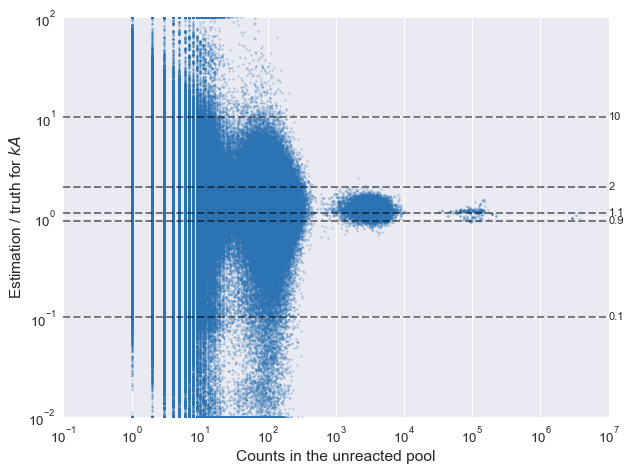

In [46]:
load_simu_count()

fig = scatter_ratio_to_truth(
    df_res=simu_count.results, df_truth=simu_count.truth,
    seq_list=simu_count.seq_list, xcol='input_counts', ycol=('kA', 'kA'),
    xlog=True, ylog=True, xlabel='Counts in the unreacted pool',
    ylim=(1e-2, 1e2), xlim=(1e-1, 1e7), figsize=(8, 6), markersize=10,
    cap_by=100, fold_guide_lines=[0.1, 0.9, 1.1, 2, 10],
)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s20.png', dpi=600)

## Figure S21: accuracy and precision dependency on input counts and kA

In [47]:
load_simu_count()

# load relevant simulation results
kA_true = simu_count.truth[['kA', 'input_counts', 'mean_counts']].rename(columns = {'kA': 'true_kA'})
kA_fold = simu_count.results[['kA', 'bs_kA_2.5%', 'bs_kA_97.5%']]
kA_fold['kA_fold_range'] = kA_fold['bs_kA_97.5%'] / kA_fold['bs_kA_2.5%']

kA_info = pd.concat([kA_true, kA_fold], axis=1)
kA_info = kA_info[~kA_info.isna().any(axis=1)]
# calculate fold error (take reciprocal if < 1)
kA_info['kA_fold_error'] = 10 ** abs(np.log10(kA_info['kA'] / kA_info['true_kA']))
kA_info

simu_count found


<ipython-input-47-67a4c0c41df9>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kA_fold['kA_fold_range'] = kA_fold['bs_kA_97.5%'] / kA_fold['bs_kA_2.5%']


,true_kA,input_counts,mean_counts,kA,bs_kA_2.5%,bs_kA_97.5%,kA_fold_range,kA_fold_error
2,0.484786,3225.0,241.0625,0.610615,0.383203,0.756887,1.975163,1.259556
5,0.206026,105.0,7.1875,0.163732,0.002905,0.857288,295.093811,1.258309
6,7.888380,3.0,0.3125,4.850690,0.000591,9.824240,16630.526395,1.626239
9,0.585214,154.0,10.6250,1.083460,0.005311,2.078612,391.359848,1.851392
12,0.289269,13.0,0.9375,1.042171,0.000563,1.708664,3033.589828,3.602771
...,...,...,...,...,...,...,...,...
999991,0.616837,6.0,0.6250,2.400499,0.000855,8.841425,10342.449832,3.891629
999993,0.401074,110.0,7.7500,0.962393,0.020101,2.307133,114.774528,2.399543
999994,35.445110,4.0,1.5625,22.732906,4.804698,86.846929,18.075418,1.559198
999996,2.414165,8.0,0.6250,5.872397,0.000581,13.625953,23457.088547,2.432476


<ipython-input-48-493aba0d8950>:2: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.hexbin(x=kA_info['input_counts'], y=kA_info['true_kA'], C=kA_info['kA_fold_error'], xscale='log', yscale='log',


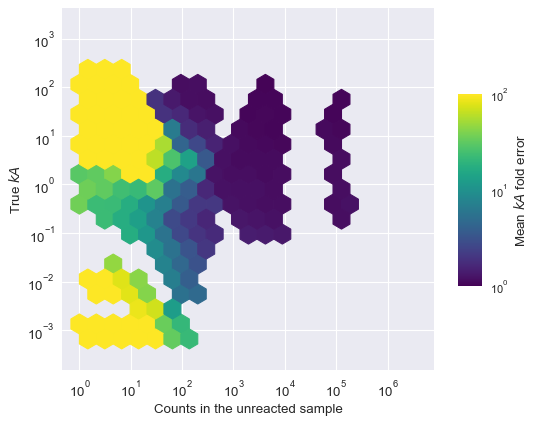

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im = ax.hexbin(x=kA_info['input_counts'], y=kA_info['true_kA'], C=kA_info['kA_fold_error'], xscale='log', yscale='log', 
                reduce_C_function=np.mean, cmap='viridis', gridsize=20, bins='log', vmax=100, vmin=1, mincnt=10)
ax.set_xlabel('Counts in the unreacted sample', fontsize=12)
ax.set_ylabel('True $kA$', fontsize=12)
ax.tick_params(labelsize=12)

cax = fig.add_axes((0.95, 0.3, 0.05, 0.4))
cbar = fig.colorbar(im, cax=cax, orientation='vertical', ticks=[1, 10, 100])
cax.set_ylabel('Mean $kA$ fold error', fontsize=12)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s21-a.pdf', bbox_inches='tight')
plt.show()


<ipython-input-49-2b938c9657e5>:2: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  im = ax.hexbin(x=kA_info['input_counts'], y=kA_info['true_kA'], C=kA_info['kA_fold_range'], xscale='log', yscale='log',


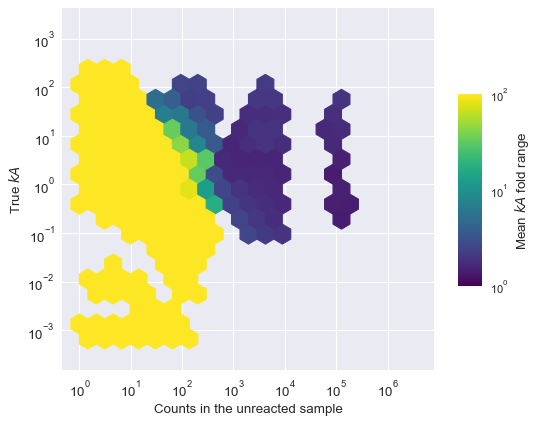

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
im = ax.hexbin(x=kA_info['input_counts'], y=kA_info['true_kA'], C=kA_info['kA_fold_range'], xscale='log', yscale='log', 
                reduce_C_function=np.mean, cmap='viridis', gridsize=20, bins='log', vmax=1e2, vmin=1, mincnt=10)
ax.set_xlabel('Counts in the unreacted sample', fontsize=12)
ax.set_ylabel('True $kA$', fontsize=12)
ax.tick_params(labelsize=12)


cax = fig.add_axes((0.95, 0.3, 0.05, 0.4))
fig.colorbar(im, cax=cax, orientation='vertical')
cax.set_ylabel('Mean $kA$ fold range', fontsize=12)
fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s21-b.pdf', bbox_inches='tight')
plt.show()

In [50]:
low_reacting_high_counts = kA_info.loc[(kA_info['input_counts'] > 1e3) & (kA_info['true_kA'] < 1)]
print(f'{len(low_reacting_high_counts)} sequences are slow reacting but abundant')
print(f"kA fold error: {low_reacting_high_counts['kA_fold_error'].mean():.2f} ± {low_reacting_high_counts['kA_fold_error'].std():.2f}")
print(f"kA fold range: {low_reacting_high_counts['kA_fold_range'].mean():.2f} ± {low_reacting_high_counts['kA_fold_range'].std():.2f}")


7089 sequences are slow reacting but abundant
kA fold error: 1.26 ± 0.17
kA fold range: 2.04 ± 0.53


## Figure S22: pool evenness (variant pool vs. enriched pool)

In [12]:
def entropy(x, min_counts=0):
    x = np.array(x)
    x = x[x > min_counts]
    x = x / x.sum()
    return - np.sum(x * np.log(x))
def normalized_entropy(x, min_counts):
    x = np.array(x)
    return entropy(x, min_counts=min_counts) / np.log(len(x > min_counts))

variant_pool found
variant_pool_res found
enriched_pool found
enriched_pool_res found


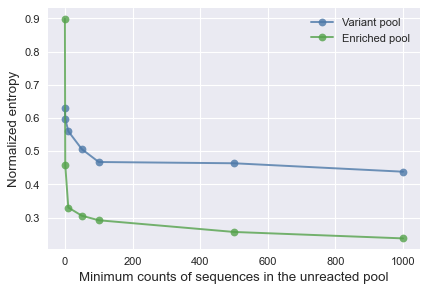

In [52]:
load_variant_pool()
load_enriched_pool()

min_counts_list = [0, 1, 10, 50, 100, 500, 1000]

variant_pool_entropy = [normalized_entropy(variant_pool.table.filtered['R0'], min_counts=min_counts) for min_counts in min_counts_list]
enriched_pool_entropy = [normalized_entropy(enriched_pool.table.nf_filtered['R0'], min_counts=min_counts) for min_counts in min_counts_list]


fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(min_counts_list, variant_pool_entropy, marker='o', color='#4C78A8', alpha=0.8, label='Variant pool')
ax.plot(min_counts_list, enriched_pool_entropy, marker='o', color='#54A24B', alpha=0.8, label='Enriched pool')
ax.set_xlabel('Minimum counts of sequences in the unreacted pool', fontsize=12)
ax.set_ylabel('Normalized entropy', fontsize=12)
ax.legend()


fig.savefig(f'{FIG_OUTPUT_DIR}/fig-s22.pdf', bbox_inches='tight')
plt.show()


## Misc. Get GC content

In [53]:
primer_f = 'GATAATACGACTCACTATAGGGAATGGATCCACATCTACGAATTC'
primer_r = 'TTCACTGCAGACTTGACGAAGCTG' # the complement for reverse


def get_gc_content(seq, hamming_range=0):
    assert(seq.count('G') + seq.count('C') + seq.count('A') + seq.count('T') == len(seq))
    if hamming_range == 0:
        return (seq.count('G') + seq.count('C')) / len(seq)
    else:
        return (seq.count('G') + seq.count('C') - hamming_range) / len(seq), (seq.count('G') + seq.count('C') + hamming_range) / len(seq)

print('WT GC-content:')
for peak in variant_pool.pool_peaks:
    print(f"{peak.name}: {get_gc_content(primer_f + peak.center_seq + primer_r):.0%}")


print('Double mutants GC-content')
for peak in variant_pool.pool_peaks:
    gc = get_gc_content(primer_f + peak.center_seq + primer_r, hamming_range=2)
    print(f"{peak.name}: ({gc[0]:.0%}, {gc[1]:.0%})")

WT GC-content:
pk2: 44%
pk1A: 43%
pk1B: 46%
pk3: 42%
Double mutants GC-content
pk2: (42%, 47%)
pk1A: (41%, 46%)
pk1B: (43%, 48%)
pk3: (40%, 44%)
